In [2]:
import psycopg2
from psycopg2.extensions import connection
from mes_proto_python.proto import offers_pb2
from google.protobuf.json_format import Parse
from typing import List

def read_proto_from_db(connection: connection) -> List[offers_pb2.Offer]:
    result = []
    try:
        with connection.cursor() as cursor:
            query = """SELECT details::TEXT FROM offers;"""
            cursor.execute(query)
            rows = cursor.fetchall()
            for row in rows:
                new_offer = offers_pb2.Offer()
                Parse(row[0], new_offer)
                result.append(new_offer)
    except psycopg2.Error as e:
        print(f"Error: {e}")
    finally:
        connection.close()
    return result


In [3]:
from typing import Dict, Any
import pandas as pd

def decimal_number_to_float(price: offers_pb2.Money):
    if price.value < 1000:
        price.value
    return price.value * 10 ** -price.scale


def offer_to_flat_dict(offer: offers_pb2.Offer) -> Dict[str, Any]:
    raw_price = decimal_number_to_float(offer.apartment.price.value)
    raw_size = decimal_number_to_float(offer.apartment.size)
    return {
        'title': offer.title,
        'description': offer.description,
        'time_scraped': offer.time_scraped.ToDatetime(),
        'price': raw_price if offer.apartment.price.value.value >= 1000 else raw_price / 100,
        'size': raw_size if raw_size > 5 else raw_size * 100,
        'address': offer.apartment.address,
        'latitude': offer.apartment.location.latitude,
        'longitude': offer.apartment.location.longitude,
        'year_built': offer.apartment.year_built if offer.apartment.year_built != 0 else None,
        'room_count': offer.apartment.room_count,
        'floor': offer.apartment.floor,
    }


def proto_list_to_dict_list(list: List[offers_pb2.Offer]):
    result = []
    for offer in list:
        try:
            result.append(offer_to_flat_dict(offer))
        except Exception as e:
            print(f"Error processing offer: {e}")
            continue  # This will move to the next item in the loop
    return result


def proto_list_to_dataframe(list: List[offers_pb2.Offer]): 
    return pd.DataFrame(proto_list_to_dict_list(list))

In [4]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [price]')
  plt.legend()
  plt.grid(True)

In [5]:
import psycopg2
from mes_proto_python.proto import offers_pb2
from google.protobuf.json_format import Parse

connection = psycopg2.connect(
    dbname='admin',
    user='admin',
    password='mysecretpassword',
    host='localhost',
    port='6020'
)

In [6]:
offers_proto = read_proto_from_db(connection)

In [7]:
offers_dataframe = proto_list_to_dataframe(offers_proto)

In [8]:
import numpy as np

def clear_dataframe(offers_dataframe):
    warsaw_only = offers_dataframe[((offers_dataframe['latitude'].between(52, 53.2)) & (offers_dataframe['longitude'].between(20, 22)))]
    only_numeric_values = warsaw_only.drop(['time_scraped', 'title', 'description', 'address'], axis=1)
    only_numeric_values.loc[only_numeric_values['room_count'] > 50, 'room_count'] = np.nan
    only_numeric_values.loc[only_numeric_values['room_count'] == 0, 'room_count'] = np.nan
    only_numeric_values.loc[only_numeric_values['year_built'] < 1800, 'year_built'] = np.nan
    for col in only_numeric_values.columns:
        only_numeric_values[col + '_is_nan'] = only_numeric_values[col].isna().astype(int)
    return only_numeric_values

def clear_dataframe2(offers_dataframe):
    clear = clear_dataframe(offers_dataframe)
    return clear[clear['price'] <= 10_000_000]

/Users/emilsroka/Desktop/git/masters/python-playground/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


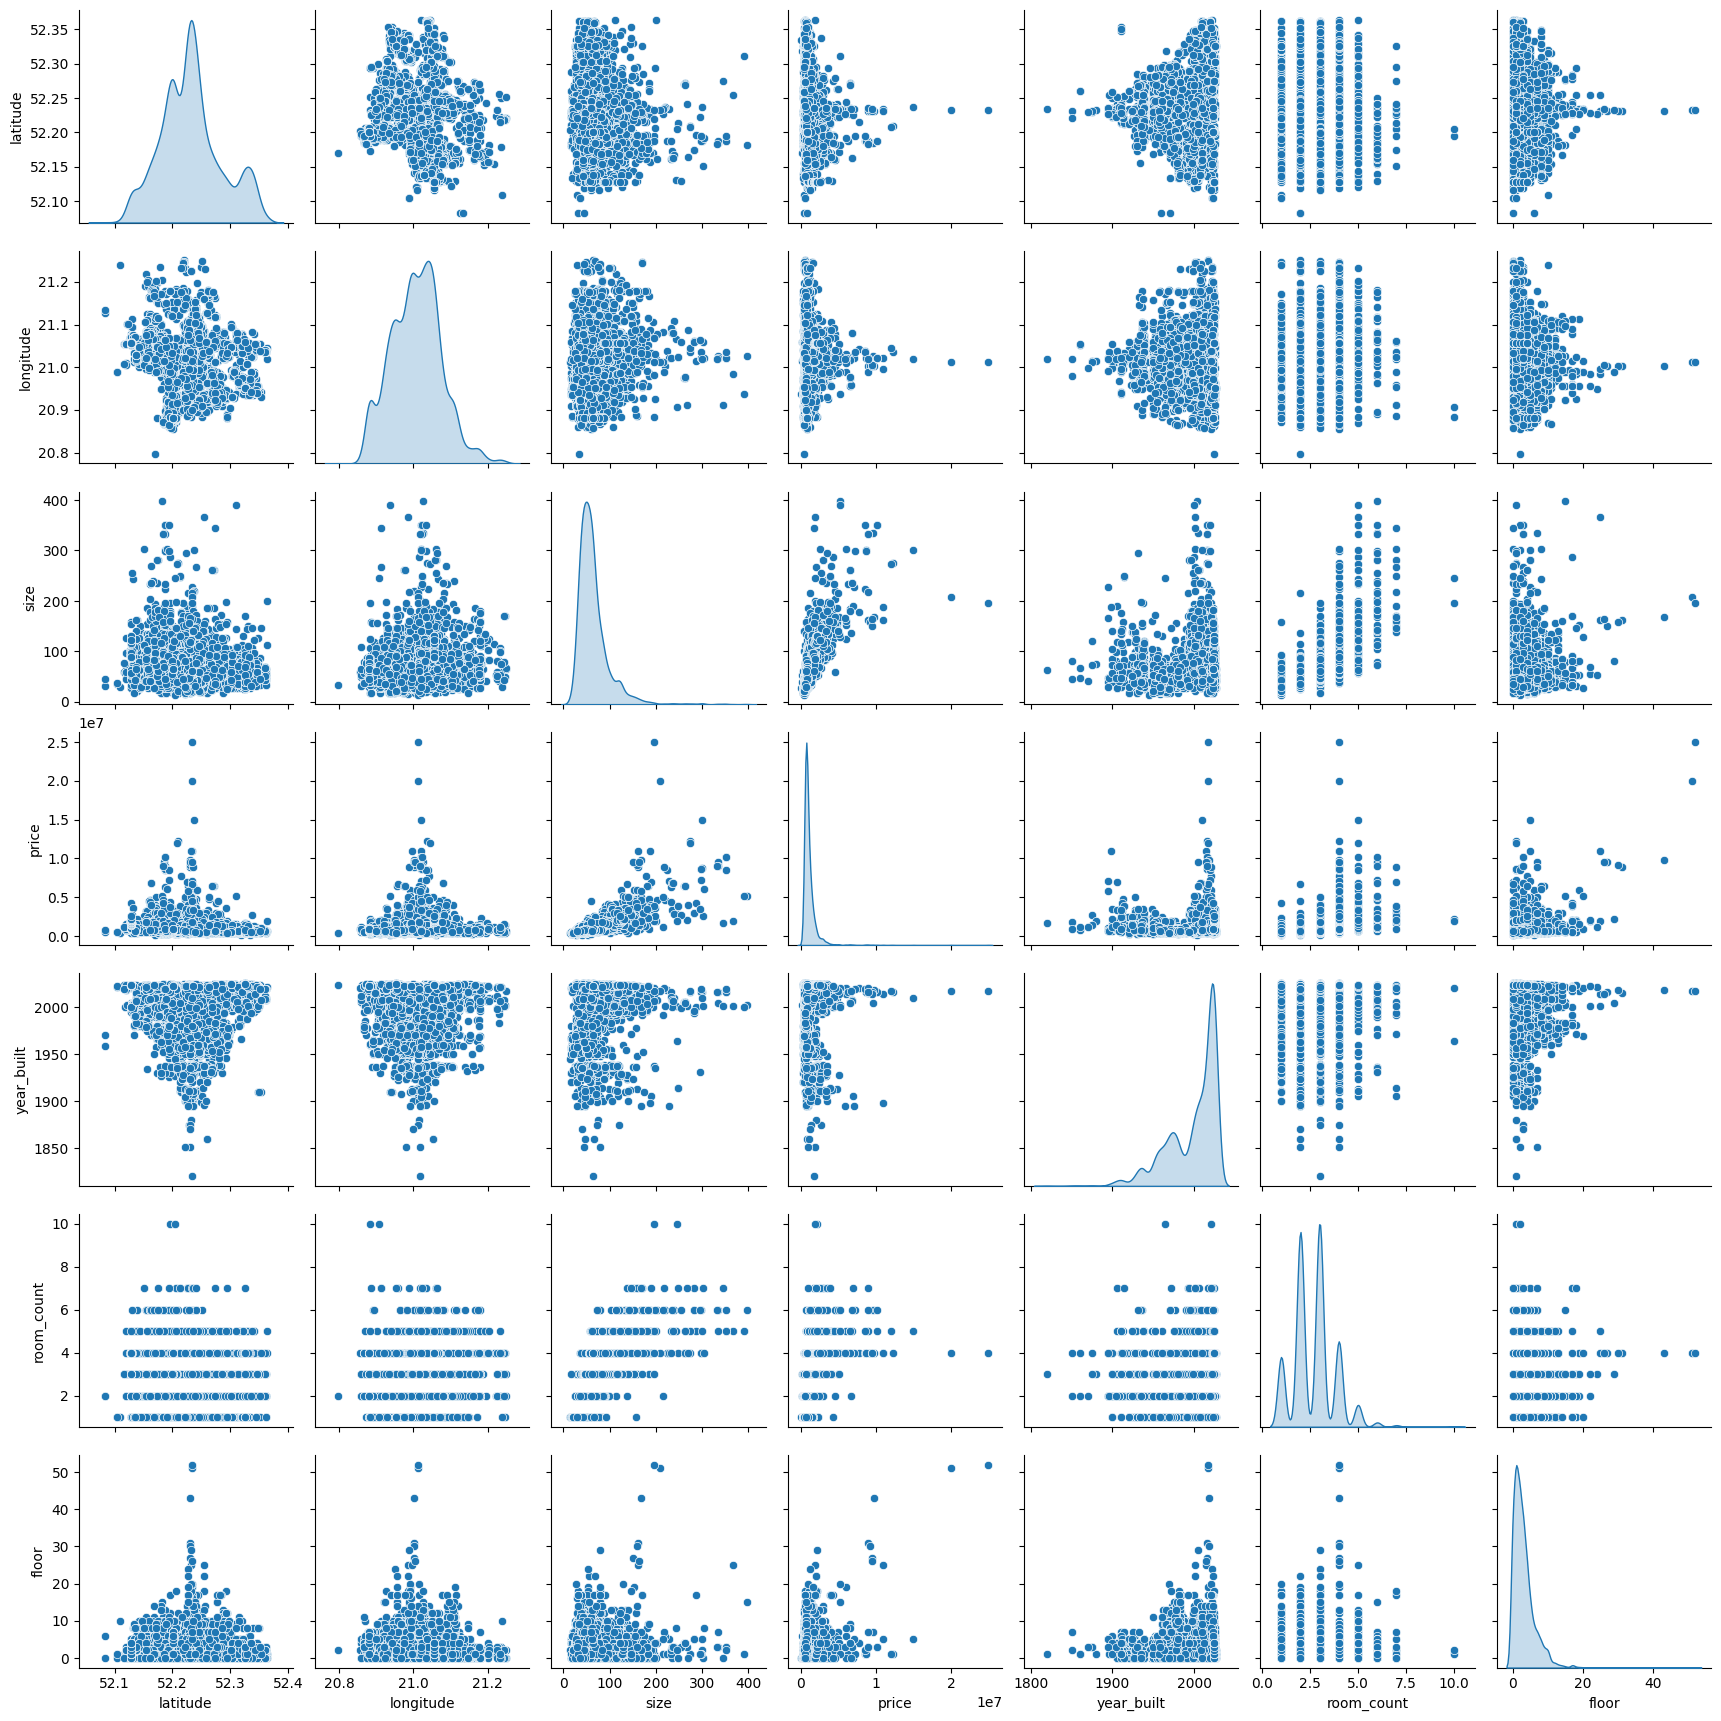

In [9]:
import seaborn as sns

clean_dataframe = clear_dataframe(offers_dataframe)
sns.pairplot(clean_dataframe[['latitude', 'longitude', 'size', 'price', 'year_built', 'room_count', 'floor']], diag_kind='kde')

In [10]:
def split(dataframe):
    train_dataset = dataframe.sample(frac=0.8, random_state=0)
    test_dataset = dataframe.drop(train_dataset.index)

    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_label = train_features.pop('price')
    test_label = test_features.pop('price')

    return train_features, train_label, train_dataset, test_features, test_label, test_dataset


train_features, train_label, train_dataset, test_features, test_label, test_dataset = split(clean_dataframe)

In [11]:

import tensorflow as tf
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

metrics=[
    'mae',
    'mape',
    r_squared,
    tf.metrics.RootMeanSquaredError(),
]

# Linear Regression

In [74]:
import tensorflow as tf

class MeanImputerLayer(tf.keras.layers.Layer):
    def __init__(self, data, **kwargs):
        super(MeanImputerLayer, self).__init__(**kwargs)
        mean_data = data.mean().values
        self.mean_values = tf.Variable(mean_data, trainable=False, dtype=tf.float32)

    def call(self, inputs):
        return tf.where(tf.math.is_nan(inputs), self.mean_values, inputs)


In [75]:
def train_model(train_features, train_label, optimizer, loss_function, epochs, metrics):
    linear_model = tf.keras.Sequential([
        MeanImputerLayer(train_features),
        tf.keras.layers.Dense(units=1)
    ])

    linear_model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    linear_model_history = linear_model.fit(
        train_features,
        train_label,
        epochs=epochs,
        verbose=0,
        validation_split = 0.2)
    
    return linear_model, linear_model_history


def evaluate(model, test_features, test_label):
    loss, *metrics = model.evaluate(test_features, test_label)
    result = {
        'loss': loss,
        'mae': metrics[0],
        'mape': metrics[1],
        'r_squared': metrics[2],
        'root_mean_squared_error': metrics[3]
    }
    return result


In [76]:
optimizer = tf.keras.optimizers.legacy.Adam
loss_functions = [
    'mean_squared_error',
    'mean_absolute_error'
]
epochs = [
    2_000,
    5_000,
    10_000
]
learning_rates = [
    0.05,
    0.2,
    0.4,
    0.5
]

results_lr = {}

for loss_function in loss_functions:
    for epoch in epochs:
        for learning_rate in learning_rates:
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            model, _ = train_model(train_features.copy(), train_label.copy(), optimizer(learning_rate=learning_rate), loss_function, epoch, metrics)
            print(optimizer, loss_function, epoch, learning_rate)
            results_lr[f"{optimizer}, {loss_function}, {epoch}, {learning_rate}"] = evaluate(model, test_features, test_label)
            print('\n\n\n')

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


KeyboardInterrupt: 

In [64]:
sorted_keys_lr = sorted(results_lr, key=lambda k: results_lr[k]['mae'])
for key in sorted_keys_lr:
    print(f"Model: {key}")
    for metric, value in results_lr[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_error, 10000, 0.5
loss: 288807.53125
mae: 288807.53125
mape: 23.23937225341797
r_squared: 0.49477463960647583
root_mean_squared_error: 678203.4375
-----------------
Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_error, 10000, 0.4
loss: 289706.625
mae: 289706.625
mape: 23.12019157409668
r_squared: 0.49324527382850647
root_mean_squared_error: 685113.5625
-----------------
Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_error, 5000, 0.5
loss: 292419.625
mae: 292419.625
mape: 23.22984504699707
r_squared: 0.4863153100013733
root_mean_squared_error: 696856.875
-----------------
Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_error, 10000, 0.2
loss: 293694.34375
mae: 293694.34375
mape: 23.425260543823242
r_squared: 0.48248422145843506
root_mean_squared_error: 700010.3125
-----------------
Model: <class 'keras.src.optimizers.legacy.adam.Adam'>, mean_absolute_

# DNN Regression

In [ ]:
def train_model_dnn(train_features, train_label, optimizer, loss_function, epochs, metrics, activation):
    linear_model_dnn = tf.keras.Sequential([
        MeanImputerLayer(train_features),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(units=1)
    ])

    linear_model_dnn.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    linear_model_history = linear_model_dnn.fit(
        train_features,
        train_label,
        epochs=epochs,
        verbose=0,
        validation_split = 0.2)
    
    return linear_model_dnn, linear_model_history


def evaluate_dnn(model, test_features, test_label):
    loss, *metrics = model.evaluate(test_features, test_label)
    result = {
        'loss': loss,
        'mae': metrics[0],
        'mape': metrics[1],
        'r_squared': metrics[2],
        'root_mean_squared_error': metrics[3]
    }
    return result


In [59]:
optimizers = [
    # tf.keras.optimizers.legacy.SGD,
    tf.keras.optimizers.legacy.RMSprop,
    tf.keras.optimizers.legacy.Adam,
    tf.keras.optimizers.legacy.Adagrad,
    # tf.keras.optimizers.legacy.Adadelta,
    # tf.keras.optimizers.legacy.Ftrl
]
loss_functions = [
    'mean_squared_error',
    'mean_absolute_error'
]
epochs = [
    1_000,
    2_000,
    5_000,
    10_000
]
learning_rates = [
    0.01,
    0.1,
    0.3,
    0.5
]
activation_functions = [
    "elu",
    "exponential",
    "relu",
    "selu",
    "sigmoid",
    "softmax",
    "softplus",
    "softsign",
    "tanh",
    "swish"
]

results_dnn = {}

for loss_function in loss_functions:
    for optimizer in optimizers:
        for epoch in epochs:
            for activation_function in activation_functions:
                for learning_rate in learning_rates:
                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                    model, _ = train_model_dnn(train_features.copy(), train_label.copy(), optimizer(learning_rate=learning_rate), loss_function, epoch, metrics, activation_function)
                    print(optimizer, loss_function, epoch, learning_rate)
                    results_dnn[f"{optimizer}, {loss_function}, {epoch}, {learning_rate} {activation_function}"] = evaluate_dnn(model, test_features.copy(), test_label.copy())
                    print('\n\n\n')


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<class 'keras.src.optimizers.legacy.rmsprop.RMSprop'> mean_absolute_error 2000 0.3
35/35 [==============================] - 0s 389us/step - loss: 292511.5938 - mae: 292511.5938 - mape: 23.2807 - r_squared: 0.4938 - root_mean_squared_error: 673420.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<class 'keras.src.optimizers.legacy.rmsprop.RMSprop'> mean_absolute_error 2000 0.3
35/35 [==============================] - 0s 394us/step - loss: nan - mae: nan - mape: nan - r_squared: nan - root_mean_squared_error: nan




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<class 'keras.src.optimizers.legacy.rmsprop.RMSprop'> mean_absolute_error 2000 0.3
35/35 [==============================] - 0s 391us/step - loss: 450537.5938 - mae: 450537.5938 - mape: 34.4080 - r_squared: -0.1505 - root_mean_squared_error: 1069793.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<class 'keras.src.optimizers.legacy.rmsprop.RMSprop'> mean_absolute_error 2000 0.3
35/35 [==============================] - 0

In [61]:
sorted_keys_dnn = sorted(results_dnn, key=lambda k: results_dnn[k]['mae'])
for key in sorted_keys_dnn:
    print(f"Model: {key}")
    for metric, value in results_dnn[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

Model: <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, mean_absolute_error, 2000, 0.3 elu
loss: 292511.59375
mae: 292511.59375
mape: 23.280654907226562
r_squared: 0.4937564432621002
root_mean_squared_error: 673420.75
-----------------
Model: <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, mean_absolute_error, 2000, 0.3 exponential
loss: nan
mae: nan
mape: nan
r_squared: nan
root_mean_squared_error: nan
-----------------
Model: <class 'keras.src.optimizers.legacy.adagrad.Adagrad'>, mean_absolute_error, 2000, 0.3 selu
loss: 276543.09375
mae: 276543.09375
mape: 22.42282485961914
r_squared: 0.5122087001800537
root_mean_squared_error: 615557.125
-----------------
Model: <class 'keras.src.optimizers.legacy.adagrad.Adagrad'>, mean_absolute_error, 2000, 0.3 relu
loss: 278858.21875
mae: 278858.21875
mape: 23.49934196472168
r_squared: 0.502552330493927
root_mean_squared_error: 621336.4375
-----------------
Model: <class 'keras.src.optimizers.legacy.adagrad.Adagrad'>, mean_absolute_

# Random Forest

In [64]:
import tensorflow_decision_forests as tfdf

def train_model_rf(train_dataset, metrics, num_trees, max_num_nodes, max_depth, split_axis, growing_strategy):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_dataset, label='price', task=tfdf.keras.Task.REGRESSION)

    model_rf = tfdf.keras.RandomForestModel(
        num_trees=num_trees,
        max_depth=max_depth,
        max_num_nodes=max_num_nodes,
        split_axis=split_axis,
        growing_strategy=growing_strategy,
        task=tfdf.keras.Task.REGRESSION,
    )

    model_rf.compile(metrics=metrics)

    linear_model_history = model_rf.fit(train_ds, verbose=0)
    
    return model_rf, linear_model_history


def evaluate_rf(model, test_dataset):
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataset, label='price', task=tfdf.keras.Task.REGRESSION)
    loss, *metrics = model.evaluate(test_ds)
    result = {
        'loss': loss,
        'mae': metrics[0],
        'mape': metrics[1],
        'r_squared': metrics[2],
        'root_mean_squared_error': metrics[3]
    }
    return result

In [81]:
nums_trees = [100, 300, 900, 1200, 2000] 
max_depths = [4, 8, 16, 32, 64, 128, 512, 1024, 256] # growing_strategy = LOCAL
max_nums_nodes = [4, 16, 64, 128, 256, 512, 1024, 2048, 5096] # growing_strategy = BEST_FIRST_GLOBAL
splits_axis = ['AXIS_ALIGNED', 'SPARSE_OBLIQUE'] 

results_rf = {}

for num_trees in nums_trees:
    for max_depth in max_depths:
            for split_axis in splits_axis:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                model, _ = train_model_rf(train_dataset.copy(), metrics, num_trees, None, max_depth, split_axis, 'LOCAL')
                results_rf[f"{num_trees}, {max_depth}, {split_axis}, LOCAL"] = evaluate_rf(model, test_dataset.copy())
                print('\n\n\n')
            
for num_trees in nums_trees:
    for max_num_nodes in max_nums_nodes:
            for split_axis in splits_axis:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                model, _ = train_model_rf(train_dataset.copy(), metrics, num_trees, max_num_nodes, None, split_axis, 'BEST_FIRST_GLOBAL')
                results_rf[f"{num_trees}, {max_num_nodes}, {split_axis}, BEST_FIRST_GLOBAL"] = evaluate_rf(model, test_dataset.copy())
                print('\n\n\n')

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw6otisfn as temporary training directory


[INFO 23-10-08 10:49:06.4925 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw6otisfn/model/ with prefix d7c0d1e9ff2f40a7
[INFO 23-10-08 10:49:06.4981 CEST decision_forest.cc:660] Model loaded with 100 root(s), 1314 node(s), and 6 input feature(s).
[INFO 23-10-08 10:49:06.4982 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 10:49:06.4982 CEST kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 295215.0625 - mape: 27.7988 - r_squared: 0.5164 - root_mean_squared_error: 615027.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo71zsnvf as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 283121.0000 - mape: 26.7962 - r_squared: 0.5508 - root_mean_squared_error: 604920.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu42_79nx as temporary training directory


[INFO 23-10-08 10:49:08.6369 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo71zsnvf/model/ with prefix 9453fcf9efa94796
[INFO 23-10-08 10:49:08.6387 CEST decision_forest.cc:660] Model loaded with 100 root(s), 1338 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:08.6387 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 10:49:09.1018 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu42_79nx/model/ with prefix cdb64d74ab344f38
[INFO 23-10-08 10:49:09.1178 CEST decision_forest.cc:660] Model loaded with 100 root(s), 14842 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:09.1178 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 194477.7188 - mape: 17.0174 - r_squared: 0.7047 - root_mean_squared_error: 571505.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4y2ux1nt as temporary training directory


[INFO 23-10-08 10:49:11.5559 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4y2ux1nt/model/ with prefix af2c629bf87b4967
[INFO 23-10-08 10:49:11.5758 CEST decision_forest.cc:660] Model loaded with 100 root(s), 14596 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:11.5759 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 186898.0000 - mape: 16.2016 - r_squared: 0.7318 - root_mean_squared_error: 550967.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf1xumdhm as temporary training directory


[INFO 23-10-08 10:49:12.5444 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf1xumdhm/model/ with prefix 7beb4125de214531
[INFO 23-10-08 10:49:12.7295 CEST decision_forest.cc:660] Model loaded with 100 root(s), 126592 node(s), and 8 input feature(s).
[INFO 23-10-08 10:49:12.7295 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143986.6875 - mape: 11.3923 - r_squared: 0.7711 - root_mean_squared_error: 531540.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxlqirncp as temporary training directory


[INFO 23-10-08 10:49:16.7540 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxlqirncp/model/ with prefix 7910064376b74611
[INFO 23-10-08 10:49:16.9174 CEST decision_forest.cc:660] Model loaded with 100 root(s), 124758 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:16.9174 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:49:16.9174 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143558.0312 - mape: 11.2986 - r_squared: 0.7988 - root_mean_squared_error: 517673.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpq_ae9pgh as temporary training directory


[INFO 23-10-08 10:49:17.6547 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpq_ae9pgh/model/ with prefix 3905e7e8cb244658
[INFO 23-10-08 10:49:17.7935 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:17.7935 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 506577.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpddr43syy as temporary training directory


[INFO 23-10-08 10:49:22.2615 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpddr43syy/model/ with prefix 3cc27d1a84654157
[INFO 23-10-08 10:49:22.4588 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:22.4589 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 498351.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgq75hrus as temporary training directory


[INFO 23-10-08 10:49:23.1790 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgq75hrus/model/ with prefix e85b99e12df640f6
[INFO 23-10-08 10:49:23.3114 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:23.3115 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 491146.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwd6304oj as temporary training directory


[INFO 23-10-08 10:49:27.5030 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwd6304oj/model/ with prefix 2f66ff3a1a6a40c9
[INFO 23-10-08 10:49:27.6702 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:27.6702 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:49:27.6703 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 485655.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj67b_hdb as temporary training directory


[INFO 23-10-08 10:49:28.6196 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj67b_hdb/model/ with prefix e90fe241f67740f2
[INFO 23-10-08 10:49:28.9736 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:28.9737 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 480584.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt8ary7o1 as temporary training directory


[INFO 23-10-08 10:49:34.7894 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt8ary7o1/model/ with prefix c40691da6c364e53
[INFO 23-10-08 10:49:34.9649 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:34.9650 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 476667.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt1tpur8j as temporary training directory


[INFO 23-10-08 10:49:35.8038 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt1tpur8j/model/ with prefix aba1570752614112
[INFO 23-10-08 10:49:35.9351 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:35.9351 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 472895.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnc19g_fg as temporary training directory


[INFO 23-10-08 10:49:40.3555 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnc19g_fg/model/ with prefix a25c4b7d01b44976
[INFO 23-10-08 10:49:40.5567 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:40.5567 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:49:40.5567 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 469967.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp97ga6099 as temporary training directory


[INFO 23-10-08 10:49:41.2167 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp97ga6099/model/ with prefix 67871bb0af6f44d9
[INFO 23-10-08 10:49:41.3603 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:41.3603 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 467045.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_zfi0nun as temporary training directory


[INFO 23-10-08 10:49:45.2549 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_zfi0nun/model/ with prefix 1b972a4cb57c4e6e
[INFO 23-10-08 10:49:45.4118 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:45.4118 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 464778.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeydayr_c as temporary training directory


[INFO 23-10-08 10:49:46.0281 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeydayr_c/model/ with prefix 4cf27d5d8be74843
[INFO 23-10-08 10:49:46.1574 CEST decision_forest.cc:660] Model loaded with 100 root(s), 139260 node(s), and 7 input feature(s).
[INFO 23-10-08 10:49:46.1575 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143090.9219 - mape: 11.2956 - r_squared: 0.7744 - root_mean_squared_error: 462444.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5ij0qp91 as temporary training directory


[INFO 23-10-08 10:49:50.0327 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5ij0qp91/model/ with prefix 11b9b6cb7f954252
[INFO 23-10-08 10:49:50.1964 CEST decision_forest.cc:660] Model loaded with 100 root(s), 140952 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:50.1964 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143768.2656 - mape: 11.2455 - r_squared: 0.7907 - root_mean_squared_error: 460640.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpafr9rey9 as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 296038.1562 - mape: 27.7541 - r_squared: 0.5072 - root_mean_squared_error: 469661.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcdo9hz92 as temporary training directory


[INFO 23-10-08 10:49:50.6680 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpafr9rey9/model/ with prefix d7a7c132e8464348
[INFO 23-10-08 10:49:50.6723 CEST decision_forest.cc:660] Model loaded with 300 root(s), 3930 node(s), and 6 input feature(s).
[INFO 23-10-08 10:49:50.6723 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 10:49:50.6723 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 283686.2188 - mape: 26.8085 - r_squared: 0.5455 - root_mean_squared_error: 475729.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3wi3cr64 as temporary training directory


[INFO 23-10-08 10:49:53.6849 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcdo9hz92/model/ with prefix 6567e2e95e6f4920
[INFO 23-10-08 10:49:53.6894 CEST decision_forest.cc:660] Model loaded with 300 root(s), 4020 node(s), and 13 input feature(s).
[INFO 23-10-08 10:49:53.6894 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 10:49:54.2504 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3wi3cr64/model/ with prefix 78c5dbf0b0254915
[INFO 23-10-08 10:49:54.2891 CEST decision_forest.cc:660] Model loaded with 300 root(s), 44378 node(s), and 8 input feature(s).
[INFO 23-10-08 10:49:54.2892 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 196178.9219 - mape: 17.1508 - r_squared: 0.7081 - root_mean_squared_error: 475021.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw7l5rxn_ as temporary training directory


[INFO 23-10-08 10:50:00.1064 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw7l5rxn_/model/ with prefix f887191342ca4c39
[INFO 23-10-08 10:50:00.1567 CEST decision_forest.cc:660] Model loaded with 300 root(s), 43716 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:00.1567 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 186209.7344 - mape: 16.1495 - r_squared: 0.7362 - root_mean_squared_error: 474065.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwhc9bwcs as temporary training directory


[INFO 23-10-08 10:50:01.2164 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwhc9bwcs/model/ with prefix fda2763c14994f0f
[INFO 23-10-08 10:50:01.6051 CEST decision_forest.cc:660] Model loaded with 300 root(s), 378752 node(s), and 8 input feature(s).
[INFO 23-10-08 10:50:01.6052 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 10:50:01.6052 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 144105.8125 - mape: 11.3372 - r_squared: 0.7790 - root_mean_squared_error: 472014.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3lu7rymm as temporary training directory


[INFO 23-10-08 10:50:11.8111 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3lu7rymm/model/ with prefix 7577783df0144aa3
[INFO 23-10-08 10:50:12.2472 CEST decision_forest.cc:660] Model loaded with 300 root(s), 375450 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:12.2472 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:50:12.2472 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 143096.0000 - mape: 11.1782 - r_squared: 0.7942 - root_mean_squared_error: 470173.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdw_4viw8 as temporary training directory


[INFO 23-10-08 10:50:13.4901 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdw_4viw8/model/ with prefix 344c1e8ae50f48c2
[INFO 23-10-08 10:50:13.8754 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:50:13.8755 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 468396.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyg5dczj1 as temporary training directory


[INFO 23-10-08 10:50:24.5941 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyg5dczj1/model/ with prefix 3464e4eba44444d4
[INFO 23-10-08 10:50:25.0846 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:25.0846 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:50:25.0846 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 466749.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpizoccspb as temporary training directory


[INFO 23-10-08 10:50:26.3423 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpizoccspb/model/ with prefix 35ecb164fb684530
[INFO 23-10-08 10:50:26.7272 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:50:26.7272 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 465210.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxhjl3kwg as temporary training directory


[INFO 23-10-08 10:50:38.2345 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxhjl3kwg/model/ with prefix 114f4e1916294b3e
[INFO 23-10-08 10:50:38.7377 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:38.7377 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:50:38.7377 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 463777.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp782q8xzl as temporary training directory


[INFO 23-10-08 10:50:40.0224 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp782q8xzl/model/ with prefix 40ec336a8b664933
[INFO 23-10-08 10:50:40.4155 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:50:40.4156 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 462431.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprn6saj9q as temporary training directory


[INFO 23-10-08 10:50:51.4333 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprn6saj9q/model/ with prefix 5462dbf3eb1a4812
[INFO 23-10-08 10:50:51.9127 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:50:51.9127 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:50:51.9127 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 461173.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4ik8vca9 as temporary training directory


[INFO 23-10-08 10:50:53.2231 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4ik8vca9/model/ with prefix 80904d0161c944e6
[INFO 23-10-08 10:50:53.6164 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:50:53.6164 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 459986.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp18lsw1av as temporary training directory


[INFO 23-10-08 10:51:04.9383 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp18lsw1av/model/ with prefix a6cd669f7bf6426c
[INFO 23-10-08 10:51:05.4219 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:51:05.4220 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:51:05.4220 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 458872.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuv_2umtw as temporary training directory


[INFO 23-10-08 10:51:06.9082 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuv_2umtw/model/ with prefix 59084ed726e74ea5
[INFO 23-10-08 10:51:07.3346 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:51:07.3347 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 457817.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph8ct_eqq as temporary training directory


[INFO 23-10-08 10:51:18.6725 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph8ct_eqq/model/ with prefix f80470b91b9d420f
[INFO 23-10-08 10:51:19.1587 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:51:19.1587 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:51:19.1587 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 456825.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprg9mvzbc as temporary training directory


[INFO 23-10-08 10:51:20.4747 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprg9mvzbc/model/ with prefix ea24ec8e3e364299
[INFO 23-10-08 10:51:20.8530 CEST decision_forest.cc:660] Model loaded with 300 root(s), 417244 node(s), and 7 input feature(s).
[INFO 23-10-08 10:51:20.8530 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143481.1094 - mape: 11.2876 - r_squared: 0.7825 - root_mean_squared_error: 455881.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgucm2fma as temporary training directory


[INFO 23-10-08 10:51:32.9661 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgucm2fma/model/ with prefix 4f78d8541826459c
[INFO 23-10-08 10:51:33.5175 CEST decision_forest.cc:660] Model loaded with 300 root(s), 422976 node(s), and 13 input feature(s).
[INFO 23-10-08 10:51:33.5175 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:51:33.5175 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 142215.2344 - mape: 11.1054 - r_squared: 0.7949 - root_mean_squared_error: 454991.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpooryqugf as temporary training directory
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 296512.6562 - mape: 27.8357 - r_squared: 0.4996 - root_mean_squared_error: 460016.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy5xka9pl as temporary training directory


[INFO 23-10-08 10:51:34.4912 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpooryqugf/model/ with prefix 154ff6149d214c43
[INFO 23-10-08 10:51:34.5032 CEST decision_forest.cc:660] Model loaded with 900 root(s), 11692 node(s), and 6 input feature(s).
[INFO 23-10-08 10:51:34.5032 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 10:51:42.9295 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy5xka9pl/model/ with prefix 060ad4a6677c4b03
[INFO 23-10-08 10:51:42.9438 CEST decision_forest.cc:660] Model loaded with 900 root(s), 12000 node(s), and 13 input feature(s).
[INFO 23-10-08 10:51:42.9438 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 283792.8438 - mape: 26.8914 - r_squared: 0.5479 - root_mean_squared_error: 463604.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfjce6opy as temporary training directory


[INFO 23-10-08 10:51:44.1456 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfjce6opy/model/ with prefix 7014a6131d9f4e75
[INFO 23-10-08 10:51:44.2745 CEST decision_forest.cc:660] Model loaded with 900 root(s), 130718 node(s), and 8 input feature(s).
[INFO 23-10-08 10:51:44.2745 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 10:51:44.2745 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 196404.5156 - mape: 17.1862 - r_squared: 0.7083 - root_mean_squared_error: 463518.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1y0iayg_ as temporary training directory


[INFO 23-10-08 10:52:01.6123 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1y0iayg_/model/ with prefix 94a7adcd633845c0
[INFO 23-10-08 10:52:01.7879 CEST decision_forest.cc:660] Model loaded with 900 root(s), 129590 node(s), and 13 input feature(s).
[INFO 23-10-08 10:52:01.7879 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:52:01.7880 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 186603.0781 - mape: 16.1439 - r_squared: 0.7342 - root_mean_squared_error: 463297.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwqnvuyi_ as temporary training directory


[INFO 23-10-08 10:52:04.5908 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwqnvuyi_/model/ with prefix ef1f4d22c1b945b6
[INFO 23-10-08 10:52:05.6455 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1132802 node(s), and 8 input feature(s).
[INFO 23-10-08 10:52:05.6455 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 143799.5625 - mape: 11.3372 - r_squared: 0.7782 - root_mean_squared_error: 462324.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprjlltsbs as temporary training directory


[INFO 23-10-08 10:52:40.4165 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprjlltsbs/model/ with prefix aa728c1fe87e4d92
[INFO 23-10-08 10:52:41.7676 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1120978 node(s), and 13 input feature(s).
[INFO 23-10-08 10:52:41.7676 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:52:41.7676 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - mae: 143508.3281 - mape: 11.1864 - r_squared: 0.7937 - root_mean_squared_error: 461460.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgf74ker9 as temporary training directory


[INFO 23-10-08 10:52:45.5862 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgf74ker9/model/ with prefix da9c86e289a44774
[INFO 23-10-08 10:52:46.8218 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:52:46.8219 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 460562.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzmnmsgkw as temporary training directory


[INFO 23-10-08 10:53:25.5322 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzmnmsgkw/model/ with prefix aa4614a1f59046d3
[INFO 23-10-08 10:53:27.0448 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:53:27.0449 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:53:27.0449 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 459783.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8b2uzy2z as temporary training directory


[INFO 23-10-08 10:53:31.2336 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8b2uzy2z/model/ with prefix 4a46ffaac1c944ee
[INFO 23-10-08 10:53:32.6089 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:53:32.6090 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 458958.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx6vxjk9d as temporary training directory


[INFO 23-10-08 10:54:13.3138 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx6vxjk9d/model/ with prefix d29ee2fa4426484c
[INFO 23-10-08 10:54:14.8663 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:54:14.8663 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:54:14.8663 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 458244.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7glomp8f as temporary training directory


[INFO 23-10-08 10:54:18.8028 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7glomp8f/model/ with prefix 2adf98d8efd04937
[INFO 23-10-08 10:54:20.0176 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:54:20.0176 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 457483.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgqbkaem5 as temporary training directory


[INFO 23-10-08 10:55:03.2700 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgqbkaem5/model/ with prefix 76bd36eb44e34043
[INFO 23-10-08 10:55:04.9266 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:55:04.9267 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:55:04.9267 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 456825.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg4b1qf4i as temporary training directory


[INFO 23-10-08 10:55:09.0375 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg4b1qf4i/model/ with prefix 865a97d8d9274b3d
[INFO 23-10-08 10:55:10.1972 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:55:10.1973 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 456121.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3zfn2dsi as temporary training directory


[INFO 23-10-08 10:55:56.6279 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3zfn2dsi/model/ with prefix 0699beefe4554dc8
[INFO 23-10-08 10:55:58.1665 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:55:58.1665 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:55:58.1665 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 455514.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfinzw5vo as temporary training directory


[INFO 23-10-08 10:56:02.2965 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfinzw5vo/model/ with prefix 65ebb97e01e2460f
[INFO 23-10-08 10:56:03.5992 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:56:03.5992 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 454860.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4fdn4_yz as temporary training directory


[INFO 23-10-08 10:56:49.5501 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4fdn4_yz/model/ with prefix 4729db1ed5714abc
[INFO 23-10-08 10:56:51.0622 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:56:51.0623 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:56:51.0623 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 454299.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgp9shmvc as temporary training directory


[INFO 23-10-08 10:56:55.2386 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgp9shmvc/model/ with prefix dfae09d6bbc544fc
[INFO 23-10-08 10:56:56.4696 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1251062 node(s), and 8 input feature(s).
[INFO 23-10-08 10:56:56.4697 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143201.1250 - mape: 11.2818 - r_squared: 0.7799 - root_mean_squared_error: 453690.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjegb0qsi as temporary training directory


[INFO 23-10-08 10:57:42.1571 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjegb0qsi/model/ with prefix d89332e9fddc4fc5
[INFO 23-10-08 10:57:43.8038 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1269520 node(s), and 13 input feature(s).
[INFO 23-10-08 10:57:43.8038 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:57:43.8038 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - mae: 143024.0938 - mape: 11.1371 - r_squared: 0.7915 - root_mean_squared_error: 453169.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpevu_2kvz as temporary training directory


[INFO 23-10-08 10:57:45.7151 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpevu_2kvz/model/ with prefix 255c99d919d94a65
[INFO 23-10-08 10:57:45.7321 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 15592 node(s), and 6 input feature(s).
[INFO 23-10-08 10:57:45.7321 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 296749.8125 - mape: 27.8293 - r_squared: 0.4973 - root_mean_squared_error: 456685.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp41p8h4s4 as temporary training directory


[INFO 23-10-08 10:58:00.8577 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp41p8h4s4/model/ with prefix 9d875fdf54e94705
[INFO 23-10-08 10:58:00.8844 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 15988 node(s), and 13 input feature(s).
[INFO 23-10-08 10:58:00.8844 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:58:00.8844 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 283829.8750 - mape: 26.8989 - r_squared: 0.5466 - root_mean_squared_error: 459194.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6pz9kz2o as temporary training directory


[INFO 23-10-08 10:58:02.8414 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6pz9kz2o/model/ with prefix f3b40b76d8394ddb
[INFO 23-10-08 10:58:03.0273 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 174284 node(s), and 8 input feature(s).
[INFO 23-10-08 10:58:03.0273 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 196785.3438 - mape: 17.2111 - r_squared: 0.7077 - root_mean_squared_error: 459229.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9sxegyz8 as temporary training directory


[INFO 23-10-08 10:58:35.4006 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9sxegyz8/model/ with prefix efe41ab3feb548ce
[INFO 23-10-08 10:58:35.6198 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 172640 node(s), and 13 input feature(s).
[INFO 23-10-08 10:58:35.6198 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:58:35.6198 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - mae: 186553.4062 - mape: 16.1450 - r_squared: 0.7332 - root_mean_squared_error: 459129.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp99rbl3op as temporary training directory


[INFO 23-10-08 10:58:41.3779 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp99rbl3op/model/ with prefix d35275affb6a43de
[INFO 23-10-08 10:58:42.9344 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1510014 node(s), and 8 input feature(s).
[INFO 23-10-08 10:58:42.9344 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - mae: 144030.3125 - mape: 11.3592 - r_squared: 0.7791 - root_mean_squared_error: 458523.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7779p1s9 as temporary training directory


[INFO 23-10-08 10:59:43.6405 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7779p1s9/model/ with prefix a6865c6de7044eba
[INFO 23-10-08 10:59:45.4316 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1493358 node(s), and 13 input feature(s).
[INFO 23-10-08 10:59:45.4316 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 10:59:45.4316 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 69ms/step - loss: 0.0000e+00 - mae: 143379.5312 - mape: 11.2029 - r_squared: 0.7945 - root_mean_squared_error: 457938.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdndip1cd as temporary training directory


[INFO 23-10-08 10:59:51.0708 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdndip1cd/model/ with prefix 65c7dfede69445cb
[INFO 23-10-08 10:59:52.6890 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 10:59:52.6891 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 457365.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8k8y8yr4 as temporary training directory


[INFO 23-10-08 11:00:52.6242 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8k8y8yr4/model/ with prefix 75418012b9da4e07
[INFO 23-10-08 11:00:54.6004 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:00:54.6004 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:00:54.6005 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 57ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 456843.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp44w8sh9l as temporary training directory


[INFO 23-10-08 11:01:00.1832 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp44w8sh9l/model/ with prefix e5e9f1918b954689
[INFO 23-10-08 11:01:01.8066 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:01:01.8066 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 456304.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzz4av3ia as temporary training directory


[INFO 23-10-08 11:02:02.8217 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzz4av3ia/model/ with prefix 60ea1b12984f443f
[INFO 23-10-08 11:02:04.9396 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:02:04.9397 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:02:04.9397 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 75ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 455812.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp841395kt as temporary training directory


[INFO 23-10-08 11:02:10.4808 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp841395kt/model/ with prefix 19ec09ba58bf4e0d
[INFO 23-10-08 11:02:12.1367 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:02:12.1368 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 455304.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpa7o2914j as temporary training directory


[INFO 23-10-08 11:03:14.0959 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpa7o2914j/model/ with prefix 7e115c56f62e4c6c
[INFO 23-10-08 11:03:16.2013 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:03:16.2014 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:03:16.2014 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 69ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 454841.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp824kwbvo as temporary training directory


[INFO 23-10-08 11:03:21.5686 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp824kwbvo/model/ with prefix 45338535d11244fd
[INFO 23-10-08 11:03:23.1759 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:03:23.1759 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 454361.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmjgpj5x1 as temporary training directory


[INFO 23-10-08 11:04:20.1945 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmjgpj5x1/model/ with prefix 39930f91271b428b
[INFO 23-10-08 11:04:22.1817 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:04:22.1818 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:04:22.1818 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 60ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 453924.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw4xofb5v as temporary training directory


[INFO 23-10-08 11:04:27.4284 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw4xofb5v/model/ with prefix c071dd9847d0454a
[INFO 23-10-08 11:04:29.4124 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:04:29.4126 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 453470.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyyxx9rkc as temporary training directory


[INFO 23-10-08 11:05:27.5896 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyyxx9rkc/model/ with prefix 9201dfbcf5ab4980
[INFO 23-10-08 11:05:30.0579 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:05:30.0580 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:05:30.0580 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 79ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 453057.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpczmkzdk4 as temporary training directory


[INFO 23-10-08 11:05:35.4265 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpczmkzdk4/model/ with prefix a0e98835e5b44b37
[INFO 23-10-08 11:05:36.9876 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1668042 node(s), and 8 input feature(s).
[INFO 23-10-08 11:05:36.9876 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143304.3750 - mape: 11.2864 - r_squared: 0.7806 - root_mean_squared_error: 452627.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7edkktn6 as temporary training directory


[INFO 23-10-08 11:06:33.2372 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7edkktn6/model/ with prefix 6bc7e993bb43486d
[INFO 23-10-08 11:06:35.3624 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1692274 node(s), and 13 input feature(s).
[INFO 23-10-08 11:06:35.3624 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:06:35.3624 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 48ms/step - loss: 0.0000e+00 - mae: 142872.1875 - mape: 11.1390 - r_squared: 0.7904 - root_mean_squared_error: 452237.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvdps2zb9 as temporary training directory


[INFO 23-10-08 11:06:37.8882 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvdps2zb9/model/ with prefix 8cd59cc17db94a8c
[INFO 23-10-08 11:06:37.9142 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 25924 node(s), and 6 input feature(s).
[INFO 23-10-08 11:06:37.9143 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 296626.0625 - mape: 27.7991 - r_squared: 0.4968 - root_mean_squared_error: 454918.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8d0ie1a1 as temporary training directory


[INFO 23-10-08 11:07:01.1287 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8d0ie1a1/model/ with prefix 1b060f2db8e14390
[INFO 23-10-08 11:07:01.1730 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 26676 node(s), and 13 input feature(s).
[INFO 23-10-08 11:07:01.1731 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:07:01.1731 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 283439.8750 - mape: 26.8553 - r_squared: 0.5479 - root_mean_squared_error: 456835.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppjprrnv0 as temporary training directory


[INFO 23-10-08 11:07:04.2477 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppjprrnv0/model/ with prefix ef904c9db9124c09
[INFO 23-10-08 11:07:04.5691 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 290686 node(s), and 8 input feature(s).
[INFO 23-10-08 11:07:04.5691 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 196586.7656 - mape: 17.1995 - r_squared: 0.7087 - root_mean_squared_error: 456879.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppy7zs_6q as temporary training directory


[INFO 23-10-08 11:07:54.0263 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppy7zs_6q/model/ with prefix 35ca08e5143b4844
[INFO 23-10-08 11:07:54.3929 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 289242 node(s), and 13 input feature(s).
[INFO 23-10-08 11:07:54.3929 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:07:54.3929 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 186227.1562 - mape: 16.1008 - r_squared: 0.7355 - root_mean_squared_error: 456824.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvlu6hket as temporary training directory


[INFO 23-10-08 11:08:01.1819 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvlu6hket/model/ with prefix 485b5279172b4430
[INFO 23-10-08 11:08:03.6250 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2520182 node(s), and 8 input feature(s).
[INFO 23-10-08 11:08:03.6251 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - mae: 143885.7344 - mape: 11.3575 - r_squared: 0.7796 - root_mean_squared_error: 456368.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjihbg8l3 as temporary training directory


[INFO 23-10-08 11:09:32.3155 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjihbg8l3/model/ with prefix 5541d9295a4c46f7
[INFO 23-10-08 11:09:35.4498 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2491216 node(s), and 13 input feature(s).
[INFO 23-10-08 11:09:35.4499 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:09:35.4499 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 87ms/step - loss: 0.0000e+00 - mae: 143200.6094 - mape: 11.1930 - r_squared: 0.7932 - root_mean_squared_error: 455944.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfgfl9e6b as temporary training directory


[INFO 23-10-08 11:09:44.1131 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfgfl9e6b/model/ with prefix 3a1728f7641e44a2
[INFO 23-10-08 11:09:46.9818 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:09:46.9818 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:09:46.9818 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 455507.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppl4_4ncr as temporary training directory


[INFO 23-10-08 11:11:22.0291 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppl4_4ncr/model/ with prefix 9097c64aed424621
[INFO 23-10-08 11:11:25.4089 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:11:25.4089 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:11:25.4089 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 95ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 455107.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpto1ig_yy as temporary training directory


[INFO 23-10-08 11:11:35.1496 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpto1ig_yy/model/ with prefix 0722d990b31b4a0d
[INFO 23-10-08 11:11:37.9124 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:11:37.9124 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:11:37.9124 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 454690.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnzwxidqr as temporary training directory


[INFO 23-10-08 11:13:11.7405 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnzwxidqr/model/ with prefix c5154b9ddf604625
[INFO 23-10-08 11:13:15.1988 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:13:15.1988 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:13:15.1988 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 121ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 454309.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph90lml4m as temporary training directory


[INFO 23-10-08 11:13:23.8916 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph90lml4m/model/ with prefix d39a3f3298534365
[INFO 23-10-08 11:13:26.5156 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:13:26.5156 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:13:26.5156 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 453910.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5cpgbyed as temporary training directory


[INFO 23-10-08 11:15:00.9395 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5cpgbyed/model/ with prefix 73864b7b400d4ecd
[INFO 23-10-08 11:15:04.2658 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:15:04.2658 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:15:04.2658 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 96ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 453546.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqwuka0bo as temporary training directory


[INFO 23-10-08 11:15:12.9297 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqwuka0bo/model/ with prefix d48f34da463e4915
[INFO 23-10-08 11:15:15.5074 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:15:15.5074 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:15:15.5074 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 453166.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2rp3lv6l as temporary training directory


[INFO 23-10-08 11:16:49.8841 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2rp3lv6l/model/ with prefix 8901d14d5db841c7
[INFO 23-10-08 11:16:53.2812 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:16:53.2813 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:16:53.2813 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 93ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 452818.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp59acxdy0 as temporary training directory


[INFO 23-10-08 11:17:03.7066 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp59acxdy0/model/ with prefix 44ee7f7b14614767
[INFO 23-10-08 11:17:06.4236 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:17:06.4236 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:17:06.4236 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 452454.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfp9f7nkg as temporary training directory


[INFO 23-10-08 11:18:41.3279 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfp9f7nkg/model/ with prefix 1d9faf08cbd74db9
[INFO 23-10-08 11:18:44.7148 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:18:44.7149 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:18:44.7149 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 90ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 452121.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgypqduir as temporary training directory


[INFO 23-10-08 11:18:53.4282 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgypqduir/model/ with prefix c3dc8dc29d694c4c
[INFO 23-10-08 11:18:56.1301 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2780092 node(s), and 8 input feature(s).
[INFO 23-10-08 11:18:56.1301 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:18:56.1301 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 143111.5625 - mape: 11.2757 - r_squared: 0.7808 - root_mean_squared_error: 451773.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbyn50hdb as temporary training directory


[INFO 23-10-08 11:20:30.6586 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbyn50hdb/model/ with prefix 051c1635e2f84d45
[INFO 23-10-08 11:20:34.1534 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2820534 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:34.1534 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:20:34.1534 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 121ms/step - loss: 0.0000e+00 - mae: 142441.3125 - mape: 11.1140 - r_squared: 0.7921 - root_mean_squared_error: 451454.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp561rvdg as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 338341.3438 - mape: 34.2406 - r_squared: 0.4343 - root_mean_squared_error: 454259.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphck8zg21 as temporary training directory


[INFO 23-10-08 11:20:36.8393 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp561rvdg/model/ with prefix c52a170cfddd4c02
[INFO 23-10-08 11:20:36.8401 CEST decision_forest.cc:660] Model loaded with 100 root(s), 700 node(s), and 5 input feature(s).
[INFO 23-10-08 11:20:36.8401 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 326704.9375 - mape: 32.9174 - r_squared: 0.4445 - root_mean_squared_error: 456645.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvd9azer6 as temporary training directory


[INFO 23-10-08 11:20:38.0531 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphck8zg21/model/ with prefix 8f331a3cb17b41ba
[INFO 23-10-08 11:20:38.0542 CEST decision_forest.cc:660] Model loaded with 100 root(s), 700 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:38.0542 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 253159.1094 - mape: 24.5857 - r_squared: 0.6484 - root_mean_squared_error: 457114.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0yamnxuv as temporary training directory


[INFO 23-10-08 11:20:38.4423 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvd9azer6/model/ with prefix a6ea301bf90341c2
[INFO 23-10-08 11:20:38.4453 CEST decision_forest.cc:660] Model loaded with 100 root(s), 3100 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:38.4453 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:20:40.5131 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0yamnxuv/model/ with prefix 136a690f441643ea
[INFO 23-10-08 11:20:40.5177 CEST decision_forest.cc:660] Model loaded with 100 root(s), 3100 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:40.5177 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 236526.6719 - mape: 22.4156 - r_squared: 0.6531 - root_mean_squared_error: 457606.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpva2x3mca as temporary training directory
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 187850.2656 - mape: 17.1789 - r_squared: 0.7301 - root_mean_squared_error: 457419.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7bl6b8zf as temporary training directory


[INFO 23-10-08 11:20:41.0033 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpva2x3mca/model/ with prefix 9cf5da8857314cd3
[INFO 23-10-08 11:20:41.0159 CEST decision_forest.cc:660] Model loaded with 100 root(s), 12700 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:41.0159 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:20:44.1716 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7bl6b8zf/model/ with prefix aaa04d32ef6d4082
[INFO 23-10-08 11:20:44.1898 CEST decision_forest.cc:660] Model loaded with 100 root(s), 12700 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:44.1898 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:20:44.1899 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 182214.5625 - mape: 16.3567 - r_squared: 0.7454 - root_mean_squared_error: 457350.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmparz3ygw2 as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 166313.2812 - mape: 14.5309 - r_squared: 0.7593 - root_mean_squared_error: 457052.7500


[INFO 23-10-08 11:20:44.6770 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmparz3ygw2/model/ with prefix c8d69766b86646ee
[INFO 23-10-08 11:20:44.7022 CEST decision_forest.cc:660] Model loaded with 100 root(s), 25500 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:44.7022 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4hx1wvmc as temporary training directory


[INFO 23-10-08 11:20:48.1236 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4hx1wvmc/model/ with prefix 55dff8338eb74195
[INFO 23-10-08 11:20:48.1590 CEST decision_forest.cc:660] Model loaded with 100 root(s), 25500 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:48.1590 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 164457.1875 - mape: 13.9823 - r_squared: 0.7621 - root_mean_squared_error: 456908.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppgg4aceg as temporary training directory


[INFO 23-10-08 11:20:48.6914 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppgg4aceg/model/ with prefix 130645e6923947ba
[INFO 23-10-08 11:20:48.7423 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:48.7423 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 152626.7656 - mape: 12.6576 - r_squared: 0.7709 - root_mean_squared_error: 456574.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpelz4m1mf as temporary training directory


[INFO 23-10-08 11:20:52.9798 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpelz4m1mf/model/ with prefix 10b7a28a73704164
[INFO 23-10-08 11:20:53.0487 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:53.0487 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 151943.2500 - mape: 12.3473 - r_squared: 0.7744 - root_mean_squared_error: 456394.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptew6wg55 as temporary training directory


[INFO 23-10-08 11:20:53.6741 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptew6wg55/model/ with prefix 43edd16e9fb24aaa
[INFO 23-10-08 11:20:53.7788 CEST decision_forest.cc:660] Model loaded with 100 root(s), 102300 node(s), and 7 input feature(s).
[INFO 23-10-08 11:20:53.7788 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 145176.1250 - mape: 11.5468 - r_squared: 0.7753 - root_mean_squared_error: 456057.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8s29rk28 as temporary training directory


[INFO 23-10-08 11:20:58.4782 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8s29rk28/model/ with prefix a6a8756dbe204eb2
[INFO 23-10-08 11:20:58.6282 CEST decision_forest.cc:660] Model loaded with 100 root(s), 102300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:20:58.6282 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:20:58.6282 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 145641.5469 - mape: 11.3763 - r_squared: 0.7763 - root_mean_squared_error: 455875.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf97p3bbm as temporary training directory


[INFO 23-10-08 11:20:59.3356 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf97p3bbm/model/ with prefix 7e26b33dcc744cb6
[INFO 23-10-08 11:20:59.4772 CEST decision_forest.cc:660] Model loaded with 100 root(s), 132190 node(s), and 8 input feature(s).
[INFO 23-10-08 11:20:59.4772 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 144631.5938 - mape: 11.4637 - r_squared: 0.7755 - root_mean_squared_error: 455549.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcmgepbq_ as temporary training directory


[INFO 23-10-08 11:21:04.6115 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcmgepbq_/model/ with prefix e64fb6630d2d4263
[INFO 23-10-08 11:21:04.7786 CEST decision_forest.cc:660] Model loaded with 100 root(s), 131778 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:04.7786 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 145163.8594 - mape: 11.2964 - r_squared: 0.7764 - root_mean_squared_error: 455374.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz662wil3 as temporary training directory


[INFO 23-10-08 11:21:05.4250 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz662wil3/model/ with prefix 993fcc834aea418c
[INFO 23-10-08 11:21:05.5748 CEST decision_forest.cc:660] Model loaded with 100 root(s), 132190 node(s), and 8 input feature(s).
[INFO 23-10-08 11:21:05.5748 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 144631.5938 - mape: 11.4637 - r_squared: 0.7755 - root_mean_squared_error: 455058.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdecug3og as temporary training directory


[INFO 23-10-08 11:21:10.6272 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdecug3og/model/ with prefix 758a5439a607445b
[INFO 23-10-08 11:21:10.8059 CEST decision_forest.cc:660] Model loaded with 100 root(s), 131778 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:10.8059 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:21:10.8059 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 145163.8594 - mape: 11.2964 - r_squared: 0.7764 - root_mean_squared_error: 454891.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0rvg5fq9 as temporary training directory


[INFO 23-10-08 11:21:11.5142 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0rvg5fq9/model/ with prefix ee3b5bc559034776
[INFO 23-10-08 11:21:11.6430 CEST decision_forest.cc:660] Model loaded with 100 root(s), 132190 node(s), and 8 input feature(s).
[INFO 23-10-08 11:21:11.6430 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 144631.5938 - mape: 11.4637 - r_squared: 0.7755 - root_mean_squared_error: 454585.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp99y8mksv as temporary training directory


[INFO 23-10-08 11:21:16.6968 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp99y8mksv/model/ with prefix 008af4fe401546af
[INFO 23-10-08 11:21:16.8622 CEST decision_forest.cc:660] Model loaded with 100 root(s), 131778 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:16.8622 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 145163.8594 - mape: 11.2964 - r_squared: 0.7764 - root_mean_squared_error: 454425.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp26a3dax_ as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 338528.4375 - mape: 34.1134 - r_squared: 0.4252 - root_mean_squared_error: 456782.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpb5vbwrn7 as temporary training directory


[INFO 23-10-08 11:21:17.3439 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp26a3dax_/model/ with prefix d690bb37d9da4167
[INFO 23-10-08 11:21:17.3459 CEST decision_forest.cc:660] Model loaded with 300 root(s), 2100 node(s), and 6 input feature(s).
[INFO 23-10-08 11:21:17.3459 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 327048.4375 - mape: 32.8447 - r_squared: 0.4481 - root_mean_squared_error: 458809.6250


[INFO 23-10-08 11:21:20.9278 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpb5vbwrn7/model/ with prefix 9e8eff021e7749b4
[INFO 23-10-08 11:21:20.9310 CEST decision_forest.cc:660] Model loaded with 300 root(s), 2100 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:20.9310 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:21:20.9310 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp25yfn2ax as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 252944.3906 - mape: 24.4961 - r_squared: 0.6415 - root_mean_squared_error: 459179.7188


[INFO 23-10-08 11:21:21.4963 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp25yfn2ax/model/ with prefix 99d5ed641eea427c
[INFO 23-10-08 11:21:21.5066 CEST decision_forest.cc:660] Model loaded with 300 root(s), 9300 node(s), and 7 input feature(s).
[INFO 23-10-08 11:21:21.5066 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9hbeoarh as temporary training directory


[INFO 23-10-08 11:21:27.6199 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9hbeoarh/model/ with prefix 288c54297c424328
[INFO 23-10-08 11:21:27.6355 CEST decision_forest.cc:660] Model loaded with 300 root(s), 9300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:27.6356 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 236872.7656 - mape: 22.5173 - r_squared: 0.6583 - root_mean_squared_error: 459499.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt03vhs8b as temporary training directory


[INFO 23-10-08 11:21:28.6555 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt03vhs8b/model/ with prefix e8b833adb9ca4bd0
[INFO 23-10-08 11:21:28.6982 CEST decision_forest.cc:660] Model loaded with 300 root(s), 38100 node(s), and 7 input feature(s).
[INFO 23-10-08 11:21:28.6983 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 187814.6562 - mape: 17.0960 - r_squared: 0.7308 - root_mean_squared_error: 459331.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0yi4rher as temporary training directory


[INFO 23-10-08 11:21:37.8907 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0yi4rher/model/ with prefix 9917ad657b6a4111
[INFO 23-10-08 11:21:37.9442 CEST decision_forest.cc:660] Model loaded with 300 root(s), 38100 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:37.9442 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:21:37.9442 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 180851.4531 - mape: 16.2447 - r_squared: 0.7561 - root_mean_squared_error: 459176.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkmrsmpfb as temporary training directory


[INFO 23-10-08 11:21:38.8064 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkmrsmpfb/model/ with prefix 578c63b40b184894
[INFO 23-10-08 11:21:38.8965 CEST decision_forest.cc:660] Model loaded with 300 root(s), 76500 node(s), and 7 input feature(s).
[INFO 23-10-08 11:21:38.8965 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 166466.7969 - mape: 14.4898 - r_squared: 0.7588 - root_mean_squared_error: 458913.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdwpkrco3 as temporary training directory


[INFO 23-10-08 11:21:48.9326 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdwpkrco3/model/ with prefix 545b3b787bdb4d98
[INFO 23-10-08 11:21:49.0330 CEST decision_forest.cc:660] Model loaded with 300 root(s), 76500 node(s), and 13 input feature(s).
[INFO 23-10-08 11:21:49.0330 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:21:49.0330 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 162652.4688 - mape: 13.8566 - r_squared: 0.7739 - root_mean_squared_error: 458691.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp493k18jl as temporary training directory


[INFO 23-10-08 11:21:50.0976 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp493k18jl/model/ with prefix 6d8d485cb17e49f2
[INFO 23-10-08 11:21:50.2608 CEST decision_forest.cc:660] Model loaded with 300 root(s), 153300 node(s), and 7 input feature(s).
[INFO 23-10-08 11:21:50.2609 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 152142.5625 - mape: 12.5737 - r_squared: 0.7712 - root_mean_squared_error: 458394.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt4wwd038 as temporary training directory


[INFO 23-10-08 11:22:01.8905 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpt4wwd038/model/ with prefix cdc3587b059b4ce6
[INFO 23-10-08 11:22:02.0744 CEST decision_forest.cc:660] Model loaded with 300 root(s), 153300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:22:02.0744 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:22:02.0744 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 150250.0625 - mape: 12.2284 - r_squared: 0.7845 - root_mean_squared_error: 458146.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpper8hdkm as temporary training directory


[INFO 23-10-08 11:22:03.3629 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpper8hdkm/model/ with prefix e9f96e20a6334b80
[INFO 23-10-08 11:22:03.6946 CEST decision_forest.cc:660] Model loaded with 300 root(s), 306900 node(s), and 7 input feature(s).
[INFO 23-10-08 11:22:03.6946 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 144795.1719 - mape: 11.4743 - r_squared: 0.7755 - root_mean_squared_error: 457846.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqmg4z5k4 as temporary training directory


[INFO 23-10-08 11:22:17.0941 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqmg4z5k4/model/ with prefix 61b6d9066df24755
[INFO 23-10-08 11:22:17.4730 CEST decision_forest.cc:660] Model loaded with 300 root(s), 306900 node(s), and 13 input feature(s).
[INFO 23-10-08 11:22:17.4730 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:22:17.4731 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 143962.0000 - mape: 11.2723 - r_squared: 0.7871 - root_mean_squared_error: 457598.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjdf49vam as temporary training directory


[INFO 23-10-08 11:22:18.8357 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjdf49vam/model/ with prefix 83cd6980a6ea4793
[INFO 23-10-08 11:22:19.2099 CEST decision_forest.cc:660] Model loaded with 300 root(s), 396906 node(s), and 8 input feature(s).
[INFO 23-10-08 11:22:19.2099 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 144224.4062 - mape: 11.3872 - r_squared: 0.7757 - root_mean_squared_error: 457306.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsmdzg6g2 as temporary training directory


[INFO 23-10-08 11:22:33.9191 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsmdzg6g2/model/ with prefix a4b3e0e072644893
[INFO 23-10-08 11:22:34.4224 CEST decision_forest.cc:660] Model loaded with 300 root(s), 395588 node(s), and 13 input feature(s).
[INFO 23-10-08 11:22:34.4225 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:22:34.4225 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 143515.9219 - mape: 11.1980 - r_squared: 0.7872 - root_mean_squared_error: 457065.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6he62amh as temporary training directory


[INFO 23-10-08 11:22:35.9687 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6he62amh/model/ with prefix c3be016e48cd41e2
[INFO 23-10-08 11:22:36.3495 CEST decision_forest.cc:660] Model loaded with 300 root(s), 396906 node(s), and 8 input feature(s).
[INFO 23-10-08 11:22:36.3496 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 144224.4062 - mape: 11.3872 - r_squared: 0.7757 - root_mean_squared_error: 456783.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprqub4v3a as temporary training directory


[INFO 23-10-08 11:22:51.2189 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprqub4v3a/model/ with prefix 7936d1a44bd94187
[INFO 23-10-08 11:22:51.6969 CEST decision_forest.cc:660] Model loaded with 300 root(s), 395588 node(s), and 13 input feature(s).
[INFO 23-10-08 11:22:51.6970 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:22:51.6970 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 143515.9219 - mape: 11.1980 - r_squared: 0.7872 - root_mean_squared_error: 456550.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqr64fdxm as temporary training directory


[INFO 23-10-08 11:22:53.2168 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqr64fdxm/model/ with prefix 3359640067954696
[INFO 23-10-08 11:22:53.6108 CEST decision_forest.cc:660] Model loaded with 300 root(s), 396906 node(s), and 8 input feature(s).
[INFO 23-10-08 11:22:53.6108 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 144224.4062 - mape: 11.3872 - r_squared: 0.7757 - root_mean_squared_error: 456276.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp33wwxg6d as temporary training directory


[INFO 23-10-08 11:23:07.6392 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp33wwxg6d/model/ with prefix 19ae36a5b3c64378
[INFO 23-10-08 11:23:08.0947 CEST decision_forest.cc:660] Model loaded with 300 root(s), 395588 node(s), and 13 input feature(s).
[INFO 23-10-08 11:23:08.0948 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:23:08.0948 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 143515.9219 - mape: 11.1980 - r_squared: 0.7872 - root_mean_squared_error: 456050.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzmnro2o3 as temporary training directory
2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 338061.0000 - mape: 33.9879 - r_squared: 0.4235 - root_mean_squared_error: 458091.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbr2s0h7z as temporary training directory


[INFO 23-10-08 11:23:08.9610 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzmnro2o3/model/ with prefix 3b2d9ef82a2c4b59
[INFO 23-10-08 11:23:08.9675 CEST decision_forest.cc:660] Model loaded with 900 root(s), 6300 node(s), and 6 input feature(s).
[INFO 23-10-08 11:23:08.9675 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:23:19.0482 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbr2s0h7z/model/ with prefix 4036ea2cdda6451e
[INFO 23-10-08 11:23:19.0572 CEST decision_forest.cc:660] Model loaded with 900 root(s), 6300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:23:19.0573 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:23:19.0573 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 328479.0625 - mape: 33.0991 - r_squared: 0.4494 - root_mean_squared_error: 459811.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsm6aem6u as temporary training directory


[INFO 23-10-08 11:23:20.1367 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsm6aem6u/model/ with prefix 519eaf4b8662481b
[INFO 23-10-08 11:23:20.1689 CEST decision_forest.cc:660] Model loaded with 900 root(s), 27900 node(s), and 7 input feature(s).
[INFO 23-10-08 11:23:20.1690 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 252533.2969 - mape: 24.4453 - r_squared: 0.6426 - root_mean_squared_error: 460124.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu8112ts_ as temporary training directory


[INFO 23-10-08 11:23:38.0489 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu8112ts_/model/ with prefix 3bae6672c836418c
[INFO 23-10-08 11:23:38.0876 CEST decision_forest.cc:660] Model loaded with 900 root(s), 27900 node(s), and 13 input feature(s).
[INFO 23-10-08 11:23:38.0877 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:23:38.0877 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 236919.8125 - mape: 22.5698 - r_squared: 0.6589 - root_mean_squared_error: 460384.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2sizeh_u as temporary training directory


[INFO 23-10-08 11:23:39.7699 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2sizeh_u/model/ with prefix ce623bb26a354dff
[INFO 23-10-08 11:23:39.9022 CEST decision_forest.cc:660] Model loaded with 900 root(s), 114300 node(s), and 7 input feature(s).
[INFO 23-10-08 11:23:39.9023 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 187274.9688 - mape: 17.0525 - r_squared: 0.7345 - root_mean_squared_error: 460225.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyve1lwya as temporary training directory


[INFO 23-10-08 11:24:05.6472 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyve1lwya/model/ with prefix cb348ecb4fc643e5
[INFO 23-10-08 11:24:05.7923 CEST decision_forest.cc:660] Model loaded with 900 root(s), 114300 node(s), and 13 input feature(s).
[INFO 23-10-08 11:24:05.7923 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:24:05.7923 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 180362.6875 - mape: 16.2156 - r_squared: 0.7593 - root_mean_squared_error: 460068.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0q3kxbe1 as temporary training directory


[INFO 23-10-08 11:24:07.7581 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0q3kxbe1/model/ with prefix 17d48bc122094e95
[INFO 23-10-08 11:24:07.9908 CEST decision_forest.cc:660] Model loaded with 900 root(s), 229500 node(s), and 7 input feature(s).
[INFO 23-10-08 11:24:07.9909 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 165967.0938 - mape: 14.4408 - r_squared: 0.7605 - root_mean_squared_error: 459828.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv6i7j_uz as temporary training directory


[INFO 23-10-08 11:24:38.0791 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv6i7j_uz/model/ with prefix 81e1c473b1c44b06
[INFO 23-10-08 11:24:38.3667 CEST decision_forest.cc:660] Model loaded with 900 root(s), 229500 node(s), and 13 input feature(s).
[INFO 23-10-08 11:24:38.3667 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:24:38.3667 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - mae: 162202.1094 - mape: 13.8096 - r_squared: 0.7777 - root_mean_squared_error: 459612.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0adagvj3 as temporary training directory


[INFO 23-10-08 11:24:40.8843 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0adagvj3/model/ with prefix 45a4dc2a93f148e5
[INFO 23-10-08 11:24:41.3323 CEST decision_forest.cc:660] Model loaded with 900 root(s), 459900 node(s), and 7 input feature(s).
[INFO 23-10-08 11:24:41.3323 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 151602.4531 - mape: 12.5204 - r_squared: 0.7739 - root_mean_squared_error: 459342.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpja2sd8et as temporary training directory


[INFO 23-10-08 11:25:14.9873 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpja2sd8et/model/ with prefix 5b64bf8740514af4
[INFO 23-10-08 11:25:15.5307 CEST decision_forest.cc:660] Model loaded with 900 root(s), 459900 node(s), and 13 input feature(s).
[INFO 23-10-08 11:25:15.5307 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:25:15.5307 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - mae: 149900.1250 - mape: 12.1855 - r_squared: 0.7882 - root_mean_squared_error: 459104.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9114i1fo as temporary training directory


[INFO 23-10-08 11:25:18.9151 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9114i1fo/model/ with prefix fae38b27a7af4b2e
[INFO 23-10-08 11:25:19.7803 CEST decision_forest.cc:660] Model loaded with 900 root(s), 920700 node(s), and 7 input feature(s).
[INFO 23-10-08 11:25:19.7803 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 144112.8906 - mape: 11.4036 - r_squared: 0.7780 - root_mean_squared_error: 458831.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp18mdlfnl as temporary training directory


[INFO 23-10-08 11:25:59.5113 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp18mdlfnl/model/ with prefix df62d2a9e6404a83
[INFO 23-10-08 11:26:00.6190 CEST decision_forest.cc:660] Model loaded with 900 root(s), 920700 node(s), and 13 input feature(s).
[INFO 23-10-08 11:26:00.6191 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:26:00.6191 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - mae: 143550.5469 - mape: 11.2157 - r_squared: 0.7910 - root_mean_squared_error: 458592.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4ngutp7y as temporary training directory


[INFO 23-10-08 11:26:04.6565 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4ngutp7y/model/ with prefix aaa09e872ff44235
[INFO 23-10-08 11:26:05.7653 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1188024 node(s), and 8 input feature(s).
[INFO 23-10-08 11:26:05.7653 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143570.3281 - mape: 11.3200 - r_squared: 0.7781 - root_mean_squared_error: 458326.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsfpel415 as temporary training directory


[INFO 23-10-08 11:26:47.7647 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsfpel415/model/ with prefix 64b5efc5cef0490a
[INFO 23-10-08 11:26:49.1852 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1184328 node(s), and 13 input feature(s).
[INFO 23-10-08 11:26:49.1852 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:26:49.1852 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - mae: 143095.9844 - mape: 11.1405 - r_squared: 0.7910 - root_mean_squared_error: 458093.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphcdhcdvj as temporary training directory


[INFO 23-10-08 11:26:53.1700 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphcdhcdvj/model/ with prefix 5d72c9b4f16f4314
[INFO 23-10-08 11:26:54.2856 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1188024 node(s), and 8 input feature(s).
[INFO 23-10-08 11:26:54.2857 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 143570.3281 - mape: 11.3200 - r_squared: 0.7781 - root_mean_squared_error: 457833.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfz37z8kz as temporary training directory


[INFO 23-10-08 11:27:37.3354 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfz37z8kz/model/ with prefix 8edc478d5c374030
[INFO 23-10-08 11:27:38.7823 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1184328 node(s), and 13 input feature(s).
[INFO 23-10-08 11:27:38.7824 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:27:38.7824 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - mae: 143095.9844 - mape: 11.1405 - r_squared: 0.7910 - root_mean_squared_error: 457607.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkgg5rjid as temporary training directory


[INFO 23-10-08 11:27:42.6775 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpkgg5rjid/model/ with prefix c14faae2828946d7
[INFO 23-10-08 11:27:43.8863 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1188024 node(s), and 8 input feature(s).
[INFO 23-10-08 11:27:43.8863 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 143570.3281 - mape: 11.3200 - r_squared: 0.7781 - root_mean_squared_error: 457354.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprbzjee07 as temporary training directory


[INFO 23-10-08 11:28:24.5145 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprbzjee07/model/ with prefix c182ba2231934508
[INFO 23-10-08 11:28:25.9395 CEST decision_forest.cc:660] Model loaded with 900 root(s), 1184328 node(s), and 13 input feature(s).
[INFO 23-10-08 11:28:25.9396 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:28:25.9396 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - mae: 143095.9844 - mape: 11.1405 - r_squared: 0.7910 - root_mean_squared_error: 457134.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoqw9pods as temporary training directory
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 337840.1562 - mape: 33.9088 - r_squared: 0.4236 - root_mean_squared_error: 458933.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdywbyt4q as temporary training directory


[INFO 23-10-08 11:28:27.6512 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoqw9pods/model/ with prefix d76e0aa5fe0c4233
[INFO 23-10-08 11:28:27.6616 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 8400 node(s), and 6 input feature(s).
[INFO 23-10-08 11:28:27.6616 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:28:41.0148 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdywbyt4q/model/ with prefix 32f1c91809a5430e
[INFO 23-10-08 11:28:41.0275 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 8400 node(s), and 13 input feature(s).
[INFO 23-10-08 11:28:41.0276 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:28:41.0276 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 328367.3438 - mape: 33.0843 - r_squared: 0.4478 - root_mean_squared_error: 460435.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp8bqlk89 as temporary training directory


[INFO 23-10-08 11:28:42.3389 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp8bqlk89/model/ with prefix 8a777fab5efe4b07
[INFO 23-10-08 11:28:42.3827 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 37200 node(s), and 7 input feature(s).
[INFO 23-10-08 11:28:42.3828 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mae: 252650.0938 - mape: 24.4458 - r_squared: 0.6421 - root_mean_squared_error: 460712.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpms9xtttc as temporary training directory


[INFO 23-10-08 11:29:04.7836 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpms9xtttc/model/ with prefix 95696e7678524937
[INFO 23-10-08 11:29:04.8361 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 37200 node(s), and 13 input feature(s).
[INFO 23-10-08 11:29:04.8361 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:29:04.8361 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mae: 237088.0938 - mape: 22.5974 - r_squared: 0.6582 - root_mean_squared_error: 460929.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvejln8oj as temporary training directory


[INFO 23-10-08 11:29:06.9093 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvejln8oj/model/ with prefix ec6090eca377497b
[INFO 23-10-08 11:29:07.0808 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 152400 node(s), and 7 input feature(s).
[INFO 23-10-08 11:29:07.0808 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 187264.8125 - mape: 17.0473 - r_squared: 0.7336 - root_mean_squared_error: 460790.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxwkrywr_ as temporary training directory


[INFO 23-10-08 11:29:40.2593 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxwkrywr_/model/ with prefix 9feab4ebdad849c0
[INFO 23-10-08 11:29:40.4608 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 152400 node(s), and 13 input feature(s).
[INFO 23-10-08 11:29:40.4609 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:29:40.4609 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - mae: 180402.4219 - mape: 16.2333 - r_squared: 0.7579 - root_mean_squared_error: 460641.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk_xpo6zl as temporary training directory


[INFO 23-10-08 11:29:43.2038 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk_xpo6zl/model/ with prefix 510763abc9764d3d
[INFO 23-10-08 11:29:43.5067 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 306000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:29:43.5068 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 166001.4375 - mape: 14.4430 - r_squared: 0.7599 - root_mean_squared_error: 460431.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpr571cjv9 as temporary training directory


[INFO 23-10-08 11:30:21.8622 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpr571cjv9/model/ with prefix 4b5d70930d2145c8
[INFO 23-10-08 11:30:22.2357 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 306000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:30:22.2357 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:30:22.2357 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - mae: 162260.0781 - mape: 13.8296 - r_squared: 0.7761 - root_mean_squared_error: 460230.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf6gr27tx as temporary training directory


[INFO 23-10-08 11:30:25.6428 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf6gr27tx/model/ with prefix 93428f03ec994eae
[INFO 23-10-08 11:30:26.2633 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 613200 node(s), and 7 input feature(s).
[INFO 23-10-08 11:30:26.2634 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 151670.7344 - mape: 12.5261 - r_squared: 0.7731 - root_mean_squared_error: 459992.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_go90qji as temporary training directory


[INFO 23-10-08 11:31:05.4732 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_go90qji/model/ with prefix 8c348b1d62bc451d
[INFO 23-10-08 11:31:06.2564 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 613200 node(s), and 13 input feature(s).
[INFO 23-10-08 11:31:06.2564 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:31:06.2564 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - mae: 149994.7969 - mape: 12.2097 - r_squared: 0.7868 - root_mean_squared_error: 459771.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpud1_utca as temporary training directory


[INFO 23-10-08 11:31:10.1760 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpud1_utca/model/ with prefix d31b51356b374b08
[INFO 23-10-08 11:31:11.3656 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1227600 node(s), and 7 input feature(s).
[INFO 23-10-08 11:31:11.3656 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 144165.5781 - mape: 11.4059 - r_squared: 0.7771 - root_mean_squared_error: 459529.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_0frme3y as temporary training directory


[INFO 23-10-08 11:31:55.9616 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_0frme3y/model/ with prefix a05ebdecde8045d0
[INFO 23-10-08 11:31:57.4292 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1227600 node(s), and 13 input feature(s).
[INFO 23-10-08 11:31:57.4292 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:31:57.4292 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 60ms/step - loss: 0.0000e+00 - mae: 143647.7812 - mape: 11.2410 - r_squared: 0.7895 - root_mean_squared_error: 459307.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi4qora12 as temporary training directory


[INFO 23-10-08 11:32:02.1081 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi4qora12/model/ with prefix def195ed7dc546b4
[INFO 23-10-08 11:32:03.6500 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1583416 node(s), and 8 input feature(s).
[INFO 23-10-08 11:32:03.6501 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 143608.3594 - mape: 11.3197 - r_squared: 0.7772 - root_mean_squared_error: 459071.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo4kosxi0 as temporary training directory


[INFO 23-10-08 11:32:50.1687 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo4kosxi0/model/ with prefix 5440e744b7dc46f0
[INFO 23-10-08 11:32:52.0488 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1577580 node(s), and 13 input feature(s).
[INFO 23-10-08 11:32:52.0489 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:32:52.0489 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 49ms/step - loss: 0.0000e+00 - mae: 143188.5156 - mape: 11.1652 - r_squared: 0.7896 - root_mean_squared_error: 458853.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpm9sgd32q as temporary training directory


[INFO 23-10-08 11:32:56.7690 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpm9sgd32q/model/ with prefix a4eedfd4227747cd
[INFO 23-10-08 11:32:58.3025 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1583416 node(s), and 8 input feature(s).
[INFO 23-10-08 11:32:58.3026 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - mae: 143608.3594 - mape: 11.3197 - r_squared: 0.7772 - root_mean_squared_error: 458623.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy6rang4_ as temporary training directory


[INFO 23-10-08 11:33:44.8339 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpy6rang4_/model/ with prefix ae791d2f6a394d62
[INFO 23-10-08 11:33:46.7899 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1577580 node(s), and 13 input feature(s).
[INFO 23-10-08 11:33:46.7899 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:33:46.7900 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 44ms/step - loss: 0.0000e+00 - mae: 143188.5156 - mape: 11.1652 - r_squared: 0.7896 - root_mean_squared_error: 458410.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwa_vz_so as temporary training directory


[INFO 23-10-08 11:33:51.4351 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwa_vz_so/model/ with prefix 596321b1564a4a8b
[INFO 23-10-08 11:33:52.9374 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1583416 node(s), and 8 input feature(s).
[INFO 23-10-08 11:33:52.9374 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 143608.3594 - mape: 11.3197 - r_squared: 0.7772 - root_mean_squared_error: 458185.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp87hoei5o as temporary training directory


[INFO 23-10-08 11:34:38.9843 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp87hoei5o/model/ with prefix 461b02f0e2e74a85
[INFO 23-10-08 11:34:40.9006 CEST decision_forest.cc:660] Model loaded with 1200 root(s), 1577580 node(s), and 13 input feature(s).
[INFO 23-10-08 11:34:40.9007 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:34:40.9007 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 45ms/step - loss: 0.0000e+00 - mae: 143188.5156 - mape: 11.1652 - r_squared: 0.7896 - root_mean_squared_error: 457978.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf6g44gon as temporary training directory
2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 338112.2188 - mape: 33.9476 - r_squared: 0.4249 - root_mean_squared_error: 459568.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3pdh4y5l as temporary training directory


[INFO 23-10-08 11:34:43.0831 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf6g44gon/model/ with prefix c90b0a44c4664373
[INFO 23-10-08 11:34:43.0960 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 14000 node(s), and 6 input feature(s).
[INFO 23-10-08 11:34:43.0960 CEST kernel.cc:1075] Use fast generic engine
[INFO 23-10-08 11:35:00.8597 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3pdh4y5l/model/ with prefix 2518bc4343ad4cdb
[INFO 23-10-08 11:35:00.8777 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 14000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:35:00.8777 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:35:00.8777 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 328525.4375 - mape: 33.1268 - r_squared: 0.4494 - root_mean_squared_error: 460884.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7hoyaqc3 as temporary training directory


[INFO 23-10-08 11:35:02.6185 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7hoyaqc3/model/ with prefix 0ac6babd64094b6b
[INFO 23-10-08 11:35:02.6809 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 62000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:35:02.6809 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 252308.9844 - mape: 24.4110 - r_squared: 0.6432 - root_mean_squared_error: 461123.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpav53takj as temporary training directory


[INFO 23-10-08 11:35:34.4840 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpav53takj/model/ with prefix 17daf1c2a2314e1c
[INFO 23-10-08 11:35:34.5694 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 62000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:35:34.5695 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:35:34.5695 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - mae: 236563.0625 - mape: 22.5668 - r_squared: 0.6624 - root_mean_squared_error: 461305.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk6r_4ymj as temporary training directory


[INFO 23-10-08 11:35:37.4981 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk6r_4ymj/model/ with prefix a49db5a81683471e
[INFO 23-10-08 11:35:37.7634 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 254000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:35:37.7634 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 186969.2031 - mape: 17.0332 - r_squared: 0.7350 - root_mean_squared_error: 461176.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg2br5n3j as temporary training directory


[INFO 23-10-08 11:36:23.9156 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpg2br5n3j/model/ with prefix 5e82de66f6f243ab
[INFO 23-10-08 11:36:24.2430 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 254000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:36:24.2431 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:36:24.2431 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - mae: 180167.1562 - mape: 16.2265 - r_squared: 0.7609 - root_mean_squared_error: 461037.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvtuk36jm as temporary training directory


[INFO 23-10-08 11:36:28.0290 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvtuk36jm/model/ with prefix 3325ba9282834f10
[INFO 23-10-08 11:36:28.9526 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 510000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:36:28.9564 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - mae: 165847.4062 - mape: 14.4442 - r_squared: 0.7618 - root_mean_squared_error: 460844.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3vaer7m5 as temporary training directory


[INFO 23-10-08 11:37:22.7420 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3vaer7m5/model/ with prefix d753c59fe604488b
[INFO 23-10-08 11:37:23.3985 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 510000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:37:23.3986 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:37:23.3986 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - mae: 162023.4219 - mape: 13.8280 - r_squared: 0.7790 - root_mean_squared_error: 460658.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqrzqseg0 as temporary training directory


[INFO 23-10-08 11:37:28.1281 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqrzqseg0/model/ with prefix 5e3ce97c57d34b48
[INFO 23-10-08 11:37:29.4872 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 1022000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:37:29.4882 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - mae: 151476.1719 - mape: 12.5203 - r_squared: 0.7751 - root_mean_squared_error: 460441.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu6pmz4ek as temporary training directory


[INFO 23-10-08 11:38:42.9677 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu6pmz4ek/model/ with prefix cc79f3e89ca64b48
[INFO 23-10-08 11:38:44.1961 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 1022000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:38:44.1962 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:38:44.1962 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 67ms/step - loss: 0.0000e+00 - mae: 149670.2500 - mape: 12.1988 - r_squared: 0.7899 - root_mean_squared_error: 460236.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnlqpvw5u as temporary training directory


[INFO 23-10-08 11:38:51.1335 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnlqpvw5u/model/ with prefix 5c5a4e188dbe4d2e
[INFO 23-10-08 11:38:53.1135 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2046000 node(s), and 7 input feature(s).
[INFO 23-10-08 11:38:53.1136 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - mae: 144057.2344 - mape: 11.4061 - r_squared: 0.7791 - root_mean_squared_error: 460016.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptoeq2kf5 as temporary training directory


[INFO 23-10-08 11:40:14.5132 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptoeq2kf5/model/ with prefix 979a19766fc54e88
[INFO 23-10-08 11:40:17.2194 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2046000 node(s), and 13 input feature(s).
[INFO 23-10-08 11:40:17.2195 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:40:17.2195 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 101ms/step - loss: 0.0000e+00 - mae: 143316.3906 - mape: 11.2293 - r_squared: 0.7926 - root_mean_squared_error: 459809.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqfjcolwi as temporary training directory


[INFO 23-10-08 11:40:27.1251 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpqfjcolwi/model/ with prefix c9958a44571b499f
[INFO 23-10-08 11:40:30.3106 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2640358 node(s), and 8 input feature(s).
[INFO 23-10-08 11:40:30.3107 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:40:30.3107 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - mae: 143495.8906 - mape: 11.3202 - r_squared: 0.7792 - root_mean_squared_error: 459593.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4bz1u39_ as temporary training directory


[INFO 23-10-08 11:41:55.9071 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4bz1u39_/model/ with prefix 2fef14b424fc4e1e
[INFO 23-10-08 11:41:59.4861 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2631414 node(s), and 13 input feature(s).
[INFO 23-10-08 11:41:59.4861 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:41:59.4862 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 98ms/step - loss: 0.0000e+00 - mae: 142845.6250 - mape: 11.1517 - r_squared: 0.7927 - root_mean_squared_error: 459390.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppni0qd6q as temporary training directory


[INFO 23-10-08 11:42:08.1091 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppni0qd6q/model/ with prefix 580db57832424632
[INFO 23-10-08 11:42:10.6116 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2640358 node(s), and 8 input feature(s).
[INFO 23-10-08 11:42:10.6116 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:42:10.6117 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - mae: 143495.8906 - mape: 11.3202 - r_squared: 0.7792 - root_mean_squared_error: 459178.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6h371ea3 as temporary training directory


[INFO 23-10-08 11:43:34.6698 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6h371ea3/model/ with prefix 04e4adf79540448b
[INFO 23-10-08 11:43:37.9713 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2631414 node(s), and 13 input feature(s).
[INFO 23-10-08 11:43:37.9714 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:43:37.9714 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 120ms/step - loss: 0.0000e+00 - mae: 142845.6250 - mape: 11.1517 - r_squared: 0.7927 - root_mean_squared_error: 458980.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1bgv0jbu as temporary training directory


[INFO 23-10-08 11:43:47.1288 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1bgv0jbu/model/ with prefix f83711c549f94e3b
[INFO 23-10-08 11:43:49.7808 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2640358 node(s), and 8 input feature(s).
[INFO 23-10-08 11:43:49.7808 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-08 11:43:49.7808 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - mae: 143495.8906 - mape: 11.3202 - r_squared: 0.7792 - root_mean_squared_error: 458773.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpti7zti_o as temporary training directory


[INFO 23-10-08 11:45:16.0733 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpti7zti_o/model/ with prefix 9cddec4829254773
[INFO 23-10-08 11:45:19.5637 CEST decision_forest.cc:660] Model loaded with 2000 root(s), 2631414 node(s), and 13 input feature(s).
[INFO 23-10-08 11:45:19.5637 CEST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-10-08 11:45:19.5637 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 102ms/step - loss: 0.0000e+00 - mae: 142845.6250 - mape: 11.1517 - r_squared: 0.7927 - root_mean_squared_error: 458579.6562






In [62]:
sorted_keys_rf = sorted(results_rf, key=lambda k: results_rf[k]['mae'])
for key in sorted_keys_rf:
    print(f"Model: {key}")
    for metric, value in results_rf[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

NameError: name 'results5' is not defined

# Gradient Boosted Trees

In [20]:
import tensorflow_decision_forests as tfdf

def train_model_gbt(train_dataset, metrics, num_trees, max_num_nodes, max_depth, split_axis, growing_strategy):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_dataset, label='price', task=tfdf.keras.Task.REGRESSION)

    model_gbt = tfdf.keras.GradientBoostedTreesModel(
        num_trees=num_trees,
        max_depth=max_depth,
        max_num_nodes=max_num_nodes,
        split_axis=split_axis,
        growing_strategy=growing_strategy,
        task=tfdf.keras.Task.REGRESSION,
    )

    model_gbt.compile(metrics=metrics)

    linear_model_history = model_gbt.fit(train_ds, verbose=0)
    
    return model_gbt, linear_model_history


def evaluate_gbt(model, test_dataset):
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataset, label='price', task=tfdf.keras.Task.REGRESSION)
    loss, *metrics = model.evaluate(test_ds)
    result = {
        'loss': loss,
        'mae': metrics[0],
        'mape': metrics[1],
        'r_squared': metrics[2],
        'root_mean_squared_error': metrics[3]
    }
    return result

In [21]:
nums_trees = [100, 300, 900, 1200, 2000] 
max_depths = [4, 8, 16, 32, 64, 128, 512, 1024, 256] # growing_strategy = LOCAL
max_nums_nodes = [4, 16, 64, 128, 256, 512, 1024, 2048, 5096] # growing_strategy = BEST_FIRST_GLOBAL
splits_axis = ['AXIS_ALIGNED', 'SPARSE_OBLIQUE'] 

results_gbt = {}

for num_trees in nums_trees:
    for max_depth in max_depths:
            for split_axis in splits_axis:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                model, _ = train_model_gbt(train_dataset.copy(), metrics, num_trees, None, max_depth, split_axis, 'LOCAL')
                results_gbt[f"{num_trees}, {max_depth}, {split_axis}, LOCAL"] = evaluate_gbt(model, test_dataset.copy())
                print('\n\n\n')
            
for num_trees in nums_trees:
    for max_num_nodes in max_nums_nodes:
            for split_axis in splits_axis:
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                model, _ = train_model_gbt(train_dataset.copy(), metrics, num_trees, max_num_nodes, None, split_axis, 'BEST_FIRST_GLOBAL')
                results_gbt[f"{num_trees}, {max_num_nodes}, {split_axis}, BEST_FIRST_GLOBAL"] = evaluate_gbt(model, test_dataset.copy())
                print('\n\n\n')

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpezq1egfk as temporary training directory


[WARNING 23-10-10 19:30:17.6992 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:17.7033 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:17.7033 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:30:20.7027 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpezq1egfk/model/ with prefix 519fafcd84d446a8
[INFO 23-10-10 19:30:20.7088 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-10 19:30:20.7088 CEST kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 180504.5625 - mape: 15.2833 - r_squared: 0.7793 - root_mean_squared_error: 549137.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplmjtv9kd as temporary training directory


[WARNING 23-10-10 19:30:21.6225 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:21.6225 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:21.6225 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 172018.3906 - mape: 13.9865 - r_squared: 0.7777 - root_mean_squared_error: 520623.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpja1unzix as temporary training directory


[INFO 23-10-10 19:30:22.9824 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplmjtv9kd/model/ with prefix 7edd24602a7e49a4
[INFO 23-10-10 19:30:22.9849 CEST decision_forest.cc:660] Model loaded with 99 root(s), 1283 node(s), and 13 input feature(s).
[INFO 23-10-10 19:30:22.9849 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:30:23.1730 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:23.1730 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:23.1730 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 161229.3438 - mape: 12.4690 - r_squared: 0.7212 - root_mean_squared_error: 515344.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz5b1snke as temporary training directory


[INFO 23-10-10 19:30:23.7465 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpja1unzix/model/ with prefix cefacf6254f547a1
[INFO 23-10-10 19:30:23.7541 CEST decision_forest.cc:660] Model loaded with 100 root(s), 6922 node(s), and 7 input feature(s).
[INFO 23-10-10 19:30:23.7542 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:30:23.9254 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:23.9254 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:23.9254 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 152161.3125 - mape: 11.7496 - r_squared: 0.7780 - root_mean_squared_error: 502595.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf3taw_5f as temporary training directory


[INFO 23-10-10 19:30:26.8319 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz5b1snke/model/ with prefix 1160544ea9de48b6
[INFO 23-10-10 19:30:26.8396 CEST decision_forest.cc:660] Model loaded with 100 root(s), 6848 node(s), and 13 input feature(s).
[INFO 23-10-10 19:30:26.8396 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:30:27.0097 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:27.0098 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:27.0098 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


[INFO 23-10-10 19:30:29.0353 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf3taw_5f/model/ with prefix 5f59debcea0a48b9
[INFO 23-10-10 19:30:29.0764 CEST decision_forest.cc:660] Model loaded with 98 root(s), 45900 node(s), and 7 input feature(s).
[INFO 23-10-10 19:30:29.0764 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143157.1562 - mape: 10.6092 - r_squared: 0.7499 - root_mean_squared_error: 503452.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnnhdmc95 as temporary training directory


[WARNING 23-10-10 19:30:29.2577 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:29.2577 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:29.2577 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


[INFO 23-10-10 19:30:37.1181 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnnhdmc95/model/ with prefix 3d275e6045814314
[INFO 23-10-10 19:30:37.1726 CEST decision_forest.cc:660] Model loaded with 93 root(s), 44417 node(s), and 13 input feature(s).
[INFO 23-10-10 19:30:37.1726 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:30:37.1727 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143945.4688 - mape: 10.7049 - r_squared: 0.7549 - root_mean_squared_error: 496293.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnyxw2_55 as temporary training directory


[WARNING 23-10-10 19:30:37.3857 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:37.3857 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:37.3858 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:30:41.2120 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnyxw2_55/model/ with prefix a2e0d21dbf1c4d69
[INFO 23-10-10 19:30:41.2935 CEST decision_forest.cc:660] Model loaded with 100 root(s), 88604 node(s), and 7 input feature(s).
[INFO 23-10-10 19:30:41.2935 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 140168.4844 - mape: 10.4495 - r_squared: 0.7720 - root_mean_squared_error: 496868.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc9aiug4t as temporary training directory


[WARNING 23-10-10 19:30:41.4843 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:41.4843 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:41.4843 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:30:54.5571 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc9aiug4t/model/ with prefix 0382239d0ba748a8
[INFO 23-10-10 19:30:54.6531 CEST decision_forest.cc:660] Model loaded with 95 root(s), 79739 node(s), and 13 input feature(s).
[INFO 23-10-10 19:30:54.6531 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:30:54.6531 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 137115.2969 - mape: 10.2444 - r_squared: 0.8001 - root_mean_squared_error: 489290.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3guicvz0 as temporary training directory


[WARNING 23-10-10 19:30:54.8858 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:54.8858 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:30:54.8858 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:31:00.1337 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3guicvz0/model/ with prefix b83f7b9d187a4078
[INFO 23-10-10 19:31:00.2606 CEST decision_forest.cc:660] Model loaded with 100 root(s), 128280 node(s), and 7 input feature(s).
[INFO 23-10-10 19:31:00.2607 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 140338.2031 - mape: 10.4472 - r_squared: 0.7704 - root_mean_squared_error: 490529.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsluo3wl_ as temporary training directory


[WARNING 23-10-10 19:31:00.4630 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:00.4630 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:00.4630 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:31:19.2561 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsluo3wl_/model/ with prefix b69cd22de9524b7b
[INFO 23-10-10 19:31:19.4049 CEST decision_forest.cc:660] Model loaded with 92 root(s), 115634 node(s), and 13 input feature(s).
[INFO 23-10-10 19:31:19.4050 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:31:19.4050 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 138783.4688 - mape: 10.2746 - r_squared: 0.7901 - root_mean_squared_error: 485475.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvk3dc76b as temporary training directory


[WARNING 23-10-10 19:31:20.0655 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:20.0656 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:20.0656 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:31:25.3520 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvk3dc76b/model/ with prefix 9096786b4faa4168
[INFO 23-10-10 19:31:25.4798 CEST decision_forest.cc:660] Model loaded with 100 root(s), 128924 node(s), and 7 input feature(s).
[INFO 23-10-10 19:31:25.4798 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 140402.2031 - mape: 10.4518 - r_squared: 0.7696 - root_mean_squared_error: 486849.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi39rk83z as temporary training directory


[WARNING 23-10-10 19:31:25.7136 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:25.7136 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:25.7136 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:31:45.0535 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi39rk83z/model/ with prefix 39e714612854492d
[INFO 23-10-10 19:31:45.2739 CEST decision_forest.cc:660] Model loaded with 95 root(s), 123971 node(s), and 13 input feature(s).
[INFO 23-10-10 19:31:45.2740 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:31:45.2740 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138872.7344 - mape: 10.2507 - r_squared: 0.7873 - root_mean_squared_error: 483031.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpttw6fx80 as temporary training directory


[WARNING 23-10-10 19:31:45.5633 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:45.5633 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:45.5633 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:31:51.8249 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpttw6fx80/model/ with prefix bc30d2f37e974c1f
[INFO 23-10-10 19:31:52.0067 CEST decision_forest.cc:660] Model loaded with 100 root(s), 128924 node(s), and 7 input feature(s).
[INFO 23-10-10 19:31:52.0068 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 140402.2031 - mape: 10.4518 - r_squared: 0.7696 - root_mean_squared_error: 484390.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp64n5inr8 as temporary training directory


[WARNING 23-10-10 19:31:52.2528 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:52.2528 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:31:52.2528 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:32:15.8093 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp64n5inr8/model/ with prefix 11c3123ae48d44de
[INFO 23-10-10 19:32:15.9738 CEST decision_forest.cc:660] Model loaded with 95 root(s), 123971 node(s), and 13 input feature(s).
[INFO 23-10-10 19:32:15.9738 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:32:15.9738 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138872.7344 - mape: 10.2507 - r_squared: 0.7873 - root_mean_squared_error: 481232.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_v0vak9y as temporary training directory


[WARNING 23-10-10 19:32:16.3474 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:32:16.3474 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:32:16.3475 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:32:22.8748 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_v0vak9y/model/ with prefix e86ac138097c4083
[INFO 23-10-10 19:32:23.0144 CEST decision_forest.cc:660] Model loaded with 100 root(s), 128924 node(s), and 7 input feature(s).
[INFO 23-10-10 19:32:23.0144 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 140402.2031 - mape: 10.4518 - r_squared: 0.7696 - root_mean_squared_error: 482538.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3vkfzjg3 as temporary training directory


[WARNING 23-10-10 19:32:23.3619 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:32:23.3619 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:32:23.3619 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:32:48.3189 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3vkfzjg3/model/ with prefix 6c1cc6f3ce04464e
[INFO 23-10-10 19:32:48.4841 CEST decision_forest.cc:660] Model loaded with 95 root(s), 123971 node(s), and 13 input feature(s).
[INFO 23-10-10 19:32:48.4842 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:32:48.4842 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 138872.7344 - mape: 10.2507 - r_squared: 0.7873 - root_mean_squared_error: 479851.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpif6j_s1c as temporary training directory


[WARNING 23-10-10 19:32:48.9192 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:32:48.9193 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:32:48.9193 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:32:54.7558 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpif6j_s1c/model/ with prefix b04fb3276bf54876
[INFO 23-10-10 19:32:54.8966 CEST decision_forest.cc:660] Model loaded with 100 root(s), 128924 node(s), and 7 input feature(s).
[INFO 23-10-10 19:32:54.8966 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 140402.2031 - mape: 10.4518 - r_squared: 0.7696 - root_mean_squared_error: 481092.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplt69jmf9 as temporary training directory


[WARNING 23-10-10 19:32:55.1607 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:32:55.1607 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:32:55.1607 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:33:17.3971 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplt69jmf9/model/ with prefix 523b59e4b2a34117
[INFO 23-10-10 19:33:17.5792 CEST decision_forest.cc:660] Model loaded with 95 root(s), 123971 node(s), and 13 input feature(s).
[INFO 23-10-10 19:33:17.5792 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:33:17.5792 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138872.7344 - mape: 10.2507 - r_squared: 0.7873 - root_mean_squared_error: 478758.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp40v7ubin as temporary training directory


[WARNING 23-10-10 19:33:17.9840 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:17.9840 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:17.9841 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:33:19.1231 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp40v7ubin/model/ with prefix 13948c18026e494a
[INFO 23-10-10 19:33:19.1259 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 175922.4844 - mape: 14.5688 - r_squared: 0.7759 - root_mean_squared_error: 478782.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpozmo8hz2 as temporary training directory


[WARNING 23-10-10 19:33:19.5125 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:19.5125 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:19.5125 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 167881.7500 - mape: 13.6257 - r_squared: 0.7744 - root_mean_squared_error: 477482.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp11hdxv80 as temporary training directory


[INFO 23-10-10 19:33:22.2132 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpozmo8hz2/model/ with prefix 575bd5d13d8c49e7
[INFO 23-10-10 19:33:22.2156 CEST decision_forest.cc:660] Model loaded with 134 root(s), 1744 node(s), and 13 input feature(s).
[INFO 23-10-10 19:33:22.2156 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:33:22.4122 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:22.4122 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:22.4122 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:33:23.2113 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp11hdxv80/model/ with prefix d39b3b2f5df646c8
[INFO 23-10-10 19:33:23.2191 CEST decision_for

2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 161431.0312 - mape: 12.4470 - r_squared: 0.7220 - root_mean_squared_error: 479213.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpko6b1p38 as temporary training directory


[WARNING 23-10-10 19:33:23.4360 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:23.4360 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:23.4360 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 152173.0156 - mape: 11.7564 - r_squared: 0.7776 - root_mean_squared_error: 477894.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp46u4o5e0 as temporary training directory


[INFO 23-10-10 19:33:28.5210 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpko6b1p38/model/ with prefix a27ebaf540e04cfe
[INFO 23-10-10 19:33:28.5295 CEST decision_forest.cc:660] Model loaded with 104 root(s), 6964 node(s), and 13 input feature(s).
[INFO 23-10-10 19:33:28.5295 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:33:28.5296 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:33:28.7115 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:28.7115 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:28.7115 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:33:31.2913 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc00

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 145047.6094 - mape: 10.6456 - r_squared: 0.7435 - root_mean_squared_error: 480250.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo99mhdht as temporary training directory


[WARNING 23-10-10 19:33:31.5606 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:31.5606 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:31.5606 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:33:42.6380 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo99mhdht/model/ with prefix 6192e6f3fc434de4
[INFO 23-10-10 19:33:42.6988 CEST decision_forest.cc:660] Model loaded with 93 root(s), 44417 node(s), and 13 input feature(s).
[INFO 23-10-10 19:33:42.6988 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:33:42.6988 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143945.4688 - mape: 10.7049 - r_squared: 0.7549 - root_mean_squared_error: 479113.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptdew7yuw as temporary training directory


[WARNING 23-10-10 19:33:43.0101 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:43.0101 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:43.0101 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:33:48.7377 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptdew7yuw/model/ with prefix 4ac34a3ddc78453f
[INFO 23-10-10 19:33:48.8360 CEST decision_forest.cc:660] Model loaded with 128 root(s), 103010 node(s), and 7 input feature(s).
[INFO 23-10-10 19:33:48.8360 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 141827.6094 - mape: 10.5003 - r_squared: 0.7644 - root_mean_squared_error: 480768.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4cjo2ngb as temporary training directory


[WARNING 23-10-10 19:33:49.0806 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:49.0806 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:33:49.0806 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:34:08.5553 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4cjo2ngb/model/ with prefix 15d30de396734460
[INFO 23-10-10 19:34:08.6660 CEST decision_forest.cc:660] Model loaded with 95 root(s), 79739 node(s), and 13 input feature(s).
[INFO 23-10-10 19:34:08.6660 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:34:08.6660 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 137115.2969 - mape: 10.2444 - r_squared: 0.8001 - root_mean_squared_error: 478779.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu1tv8t7q as temporary training directory


[WARNING 23-10-10 19:34:08.9582 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:34:08.9582 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:34:08.9582 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:34:19.2939 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu1tv8t7q/model/ with prefix 111aea20e2034632
[INFO 23-10-10 19:34:19.4632 CEST decision_forest.cc:660] Model loaded with 132 root(s), 169436 node(s), and 7 input feature(s).
[INFO 23-10-10 19:34:19.4633 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 19:34:19.4633 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 142074.7344 - mape: 10.5018 - r_squared: 0.7642 - root_mean_squared_error: 480373.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpl6l_9fcf as temporary training directory


[WARNING 23-10-10 19:34:19.8715 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:34:19.8715 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:34:19.8715 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:34:45.6122 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpl6l_9fcf/model/ with prefix dd1fc002099242f6
[INFO 23-10-10 19:34:45.7525 CEST decision_forest.cc:660] Model loaded with 92 root(s), 115634 node(s), and 13 input feature(s).
[INFO 23-10-10 19:34:45.7526 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:34:45.7526 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 138783.4688 - mape: 10.2746 - r_squared: 0.7901 - root_mean_squared_error: 478777.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv5dynovz as temporary training directory


[WARNING 23-10-10 19:34:46.0768 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:34:46.0768 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:34:46.0768 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:34:55.6605 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv5dynovz/model/ with prefix 330d29260f5c40bb
[INFO 23-10-10 19:34:55.8791 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:34:55.8792 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 19:34:55.8792 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480439.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppyw64ti4 as temporary training directory


[WARNING 23-10-10 19:34:56.8144 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:34:56.8144 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:34:56.8145 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:35:31.9538 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppyw64ti4/model/ with prefix 76b4ff9f30ac4147
[INFO 23-10-10 19:35:32.1383 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:35:32.1384 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:35:32.1384 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 479090.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnug9bb0n as temporary training directory


[WARNING 23-10-10 19:35:32.4778 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:35:32.4780 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:35:32.4780 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:35:42.8009 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnug9bb0n/model/ with prefix 0b9669d974a24895
[INFO 23-10-10 19:35:43.2359 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:35:43.2359 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 19:35:43.2360 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480637.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgjxah3nb as temporary training directory


[WARNING 23-10-10 19:35:43.5989 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:35:43.5990 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:35:43.5990 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:36:15.7643 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgjxah3nb/model/ with prefix f712ed87f06b4125
[INFO 23-10-10 19:36:15.9398 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:36:15.9399 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:36:15.9399 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 479364.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0dtnlewq as temporary training directory


[WARNING 23-10-10 19:36:16.2608 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:36:16.2609 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:36:16.2609 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:36:25.1665 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0dtnlewq/model/ with prefix 15233f3c03d74b9a
[INFO 23-10-10 19:36:25.3466 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:36:25.3466 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480812.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpngp3dnym as temporary training directory


[WARNING 23-10-10 19:36:25.6135 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:36:25.6135 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:36:25.6135 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:36:57.3268 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpngp3dnym/model/ with prefix 9ba92778fd1741eb
[INFO 23-10-10 19:36:57.4940 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:36:57.4940 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:36:57.4940 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 479607.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmpcff6l2 as temporary training directory


[WARNING 23-10-10 19:36:57.8055 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:36:57.8056 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:36:57.8056 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:37:06.4457 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmpcff6l2/model/ with prefix c6ca46a2b3d64e51
[INFO 23-10-10 19:37:06.6151 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:37:06.6151 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480967.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2_hjrswa as temporary training directory


[WARNING 23-10-10 19:37:06.8402 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:06.8402 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:06.8402 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:37:37.3078 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2_hjrswa/model/ with prefix f11a87814d734498
[INFO 23-10-10 19:37:37.4710 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:37:37.4711 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:37:37.4711 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 479824.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2t_drqdz as temporary training directory


[WARNING 23-10-10 19:37:37.8359 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:37.8359 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:37.8359 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 175922.4844 - mape: 14.5688 - r_squared: 0.7759 - root_mean_squared_error: 479809.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnmiuk91e as temporary training directory


[INFO 23-10-10 19:37:38.3054 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2t_drqdz/model/ with prefix 3fcedf3d6b844e33
[INFO 23-10-10 19:37:38.3078 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:37:38.4758 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:38.4759 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:38.4759 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 167881.7500 - mape: 13.6257 - r_squared: 0.7744 - root_mean_squared_error: 479085.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk69i4_5i as temporary training directory


[INFO 23-10-10 19:37:40.5661 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpnmiuk91e/model/ with prefix ec59767e3f8a43f2
[INFO 23-10-10 19:37:40.5685 CEST decision_forest.cc:660] Model loaded with 134 root(s), 1744 node(s), and 13 input feature(s).
[INFO 23-10-10 19:37:40.5685 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:37:40.7582 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:40.7582 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:40.7582 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 161431.0312 - mape: 12.4470 - r_squared: 0.7220 - root_mean_squared_error: 479994.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8qlvxlsc as temporary training directory


[INFO 23-10-10 19:37:41.5135 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk69i4_5i/model/ with prefix b216b9412a09404f
[INFO 23-10-10 19:37:41.5211 CEST decision_forest.cc:660] Model loaded with 130 root(s), 8354 node(s), and 7 input feature(s).
[INFO 23-10-10 19:37:41.5211 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:37:41.6869 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:41.6869 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:41.6869 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 152173.0156 - mape: 11.7564 - r_squared: 0.7776 - root_mean_squared_error: 479237.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp12s01rf6 as temporary training directory


[INFO 23-10-10 19:37:45.6829 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8qlvxlsc/model/ with prefix f3bd669f46944ae0
[INFO 23-10-10 19:37:45.6922 CEST decision_forest.cc:660] Model loaded with 104 root(s), 6964 node(s), and 13 input feature(s).
[INFO 23-10-10 19:37:45.6922 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:37:45.8790 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:45.8790 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:45.8790 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:37:48.3350 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp12s01rf6/model/ with prefix e79e6c6f18764756
[INFO 23-10-10 19:37:48.3806 CEST decision_for

2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 145047.6094 - mape: 10.6456 - r_squared: 0.7435 - root_mean_squared_error: 480549.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprfx14shx as temporary training directory


[WARNING 23-10-10 19:37:48.5687 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:48.5687 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:48.5687 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:37:58.2343 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprfx14shx/model/ with prefix a3edbed3a62e41c4
[INFO 23-10-10 19:37:58.2904 CEST decision_forest.cc:660] Model loaded with 93 root(s), 44417 node(s), and 13 input feature(s).
[INFO 23-10-10 19:37:58.2904 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143945.4688 - mape: 10.7049 - r_squared: 0.7549 - root_mean_squared_error: 479882.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplbp7amvw as temporary training directory


[WARNING 23-10-10 19:37:58.5095 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:58.5095 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:37:58.5095 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:38:03.4380 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplbp7amvw/model/ with prefix 428e6bde3a15459f
[INFO 23-10-10 19:38:03.5380 CEST decision_forest.cc:660] Model loaded with 128 root(s), 103010 node(s), and 7 input feature(s).
[INFO 23-10-10 19:38:03.5381 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 19:38:03.5381 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 141827.6094 - mape: 10.5003 - r_squared: 0.7644 - root_mean_squared_error: 480841.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpshwjgytw as temporary training directory


[WARNING 23-10-10 19:38:03.7442 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:38:03.7442 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:38:03.7442 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:38:22.4750 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpshwjgytw/model/ with prefix fa0904f71ca248c0
[INFO 23-10-10 19:38:22.5722 CEST decision_forest.cc:660] Model loaded with 95 root(s), 79739 node(s), and 13 input feature(s).
[INFO 23-10-10 19:38:22.5722 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:38:22.5722 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 137115.2969 - mape: 10.2444 - r_squared: 0.8001 - root_mean_squared_error: 479648.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpczg7r97y as temporary training directory


[WARNING 23-10-10 19:38:22.8476 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:38:22.8480 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:38:22.8480 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:38:31.6444 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpczg7r97y/model/ with prefix d6f4cdb6f03c4504
[INFO 23-10-10 19:38:31.8089 CEST decision_forest.cc:660] Model loaded with 132 root(s), 169436 node(s), and 7 input feature(s).
[INFO 23-10-10 19:38:31.8089 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 142074.7344 - mape: 10.5018 - r_squared: 0.7642 - root_mean_squared_error: 480598.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv0ha9w73 as temporary training directory


[WARNING 23-10-10 19:38:32.0235 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:38:32.0236 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:38:32.0236 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:38:55.4403 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv0ha9w73/model/ with prefix 3d2782acf23a4da0
[INFO 23-10-10 19:38:55.5718 CEST decision_forest.cc:660] Model loaded with 92 root(s), 115634 node(s), and 13 input feature(s).
[INFO 23-10-10 19:38:55.5718 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:38:55.5719 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138783.4688 - mape: 10.2746 - r_squared: 0.7901 - root_mean_squared_error: 479609.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_9aqutub as temporary training directory


[WARNING 23-10-10 19:38:55.8306 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:38:55.8306 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:38:55.8306 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:39:04.9254 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_9aqutub/model/ with prefix 79d3168878b84622
[INFO 23-10-10 19:39:05.1000 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:39:05.1000 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480630.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpb7gd4n85 as temporary training directory


[WARNING 23-10-10 19:39:05.3169 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:39:05.3169 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:39:05.3169 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:39:36.0955 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpb7gd4n85/model/ with prefix ed836af8a96345a1
[INFO 23-10-10 19:39:36.2645 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:39:36.2645 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:39:36.2646 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 479773.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc0z9236q as temporary training directory


[WARNING 23-10-10 19:39:36.5987 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:39:36.5987 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:39:36.5987 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:39:46.2121 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc0z9236q/model/ with prefix fa53908c94f848a6
[INFO 23-10-10 19:39:46.3789 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:39:46.3789 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 19:39:46.3789 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480749.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8szucnep as temporary training directory


[WARNING 23-10-10 19:39:46.6179 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:39:46.6180 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:39:46.6180 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:40:19.3322 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8szucnep/model/ with prefix 9dbd303308f3445a
[INFO 23-10-10 19:40:19.5192 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:40:19.5193 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:40:19.5193 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 479924.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_jvvx_2m as temporary training directory


[WARNING 23-10-10 19:40:20.3376 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:40:20.3376 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:40:20.3376 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:40:28.6623 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_jvvx_2m/model/ with prefix 7fc3a573b98c4d32
[INFO 23-10-10 19:40:28.8490 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:40:28.8490 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480859.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6b8dkflf as temporary training directory


[WARNING 23-10-10 19:40:29.0757 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:40:29.0757 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:40:29.0757 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:40:59.7412 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6b8dkflf/model/ with prefix 2be4730345e34aed
[INFO 23-10-10 19:40:59.9145 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:40:59.9145 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:40:59.9146 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480063.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphm1mcae5 as temporary training directory


[WARNING 23-10-10 19:41:00.2475 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:00.2476 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:00.2476 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:41:08.7058 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphm1mcae5/model/ with prefix 9ea826acf9f84e7b
[INFO 23-10-10 19:41:08.8827 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:41:08.8827 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480961.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk2ie1r15 as temporary training directory


[WARNING 23-10-10 19:41:09.1204 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:09.1204 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:09.1204 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:41:40.0074 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk2ie1r15/model/ with prefix 9aa0e701352c49f4
[INFO 23-10-10 19:41:40.1973 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:41:40.1973 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:41:40.1973 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480192.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpex3qzcdd as temporary training directory


[WARNING 23-10-10 19:41:40.5675 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:40.5676 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:40.5676 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 175922.4844 - mape: 14.5688 - r_squared: 0.7759 - root_mean_squared_error: 480175.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph9hmgypj as temporary training directory


[INFO 23-10-10 19:41:41.0959 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpex3qzcdd/model/ with prefix c01b90f4f64f4c50
[INFO 23-10-10 19:41:41.0984 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:41:41.2786 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:41.2786 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:41.2786 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 167881.7500 - mape: 13.6257 - r_squared: 0.7744 - root_mean_squared_error: 479674.0625


[INFO 23-10-10 19:41:43.8770 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph9hmgypj/model/ with prefix c6ea8f1cb58447b7
[INFO 23-10-10 19:41:43.8796 CEST decision_forest.cc:660] Model loaded with 134 root(s), 1744 node(s), and 13 input feature(s).
[INFO 23-10-10 19:41:43.8796 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1jq2yqhe as temporary training directory


[WARNING 23-10-10 19:41:44.0813 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:44.0814 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:44.0814 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:41:44.9528 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1jq2yqhe/model/ with prefix 60d5e6fb1dfd44a2
[INFO 23-10-10 19:41:44.9618 CEST decision_forest.cc:660] Model loaded with 130 root(s), 8354 node(s), and 7 input feature(s).
[INFO 23-10-10 19:41:44.9619 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 161431.0312 - mape: 12.4470 - r_squared: 0.7220 - root_mean_squared_error: 480290.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmswjveuf as temporary training directory


[WARNING 23-10-10 19:41:45.1698 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:45.1698 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:45.1698 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:41:49.4099 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmswjveuf/model/ with prefix 1d0436b234404ff6
[INFO 23-10-10 19:41:49.4207 CEST decision_forest.cc:660] Model loaded with 104 root(s), 6964 node(s), and 13 input feature(s).
[INFO 23-10-10 19:41:49.4207 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 152173.0156 - mape: 11.7564 - r_squared: 0.7776 - root_mean_squared_error: 479759.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptq_81gzk as temporary training directory


[WARNING 23-10-10 19:41:49.6298 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:49.6298 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:49.6298 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:41:52.1093 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmptq_81gzk/model/ with prefix 5f3eb457b8474cee
[INFO 23-10-10 19:41:52.1601 CEST decision_forest.cc:660] Model loaded with 136 root(s), 49390 node(s), and 7 input feature(s).
[INFO 23-10-10 19:41:52.1601 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 19:41:52.1601 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 145047.6094 - mape: 10.6456 - r_squared: 0.7435 - root_mean_squared_error: 480668.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2x7xsv0y as temporary training directory


[WARNING 23-10-10 19:41:52.3429 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:52.3430 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:41:52.3430 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:42:02.0275 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2x7xsv0y/model/ with prefix 98f0d22d46f347b8
[INFO 23-10-10 19:42:02.0834 CEST decision_forest.cc:660] Model loaded with 93 root(s), 44417 node(s), and 13 input feature(s).
[INFO 23-10-10 19:42:02.0835 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143945.4688 - mape: 10.7049 - r_squared: 0.7549 - root_mean_squared_error: 480196.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp26vtfpkg as temporary training directory


[WARNING 23-10-10 19:42:02.2931 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:42:02.2931 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:42:02.2931 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:42:07.2380 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp26vtfpkg/model/ with prefix 04b04c38102b4c04
[INFO 23-10-10 19:42:07.3407 CEST decision_forest.cc:660] Model loaded with 128 root(s), 103010 node(s), and 7 input feature(s).
[INFO 23-10-10 19:42:07.3407 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 19:42:07.3407 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 141827.6094 - mape: 10.5003 - r_squared: 0.7644 - root_mean_squared_error: 480872.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxdrqpvcm as temporary training directory


[WARNING 23-10-10 19:42:07.5404 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:42:07.5404 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:42:07.5404 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:42:26.0631 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpxdrqpvcm/model/ with prefix 11f20a97b40d4dcc
[INFO 23-10-10 19:42:26.1673 CEST decision_forest.cc:660] Model loaded with 95 root(s), 79739 node(s), and 13 input feature(s).
[INFO 23-10-10 19:42:26.1674 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:42:26.1674 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 137115.2969 - mape: 10.2444 - r_squared: 0.8001 - root_mean_squared_error: 480019.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5wav6are as temporary training directory


[WARNING 23-10-10 19:42:26.4542 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:42:26.4543 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:42:26.4543 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:42:34.5474 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5wav6are/model/ with prefix 49cb6d2acca142aa
[INFO 23-10-10 19:42:34.7102 CEST decision_forest.cc:660] Model loaded with 132 root(s), 169436 node(s), and 7 input feature(s).
[INFO 23-10-10 19:42:34.7102 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142074.7344 - mape: 10.5018 - r_squared: 0.7642 - root_mean_squared_error: 480696.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwac2xgqe as temporary training directory


[WARNING 23-10-10 19:42:34.9447 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:42:34.9448 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:42:34.9448 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:43:00.3922 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwac2xgqe/model/ with prefix c536601a521a4dd2
[INFO 23-10-10 19:43:00.5328 CEST decision_forest.cc:660] Model loaded with 92 root(s), 115634 node(s), and 13 input feature(s).
[INFO 23-10-10 19:43:00.5329 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:43:00.5329 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 138783.4688 - mape: 10.2746 - r_squared: 0.7901 - root_mean_squared_error: 479980.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx469l3mz as temporary training directory


[WARNING 23-10-10 19:43:00.9382 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:43:00.9383 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:43:00.9383 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:43:09.1375 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx469l3mz/model/ with prefix bd3956f9dcf246c8
[INFO 23-10-10 19:43:09.3123 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:43:09.3124 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480716.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplevm5z0j as temporary training directory


[WARNING 23-10-10 19:43:09.5343 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:43:09.5343 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:43:09.5343 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:43:45.9242 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplevm5z0j/model/ with prefix 3f92321ffc694f38
[INFO 23-10-10 19:43:46.1222 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:43:46.1222 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:43:46.1222 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480089.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprlapdzdw as temporary training directory


[WARNING 23-10-10 19:43:46.5433 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:43:46.5433 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:43:46.5434 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:43:56.2187 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprlapdzdw/model/ with prefix c0620a0011c14772
[INFO 23-10-10 19:43:56.3962 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:43:56.3963 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 19:43:56.3963 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480801.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpefvfvuod as temporary training directory


[WARNING 23-10-10 19:43:56.6190 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:43:56.6190 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:43:56.6191 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:44:33.6852 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpefvfvuod/model/ with prefix b420cbd297d34e4d
[INFO 23-10-10 19:44:33.8763 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:44:33.8764 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:44:33.8764 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480191.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgjev1cr7 as temporary training directory


[WARNING 23-10-10 19:44:34.3021 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:44:34.3022 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:44:34.3022 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:44:43.1003 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpgjev1cr7/model/ with prefix 3f647cee1edf4438
[INFO 23-10-10 19:44:43.2688 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:44:43.2688 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480882.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp6_06pzu as temporary training directory


[WARNING 23-10-10 19:44:43.4900 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:44:43.4901 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:44:43.4901 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:45:14.9472 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp6_06pzu/model/ with prefix 700ea3ac2f4d4ab6
[INFO 23-10-10 19:45:15.1121 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:45:15.1121 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:45:15.1121 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480287.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjnf23_u1 as temporary training directory


[WARNING 23-10-10 19:45:15.4404 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:15.4404 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:15.4404 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:45:24.2675 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjnf23_u1/model/ with prefix 2c3583110460409e
[INFO 23-10-10 19:45:24.4389 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:45:24.4389 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480957.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9eb8hka9 as temporary training directory


[WARNING 23-10-10 19:45:24.7496 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:24.7497 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:24.7497 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:45:55.4035 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9eb8hka9/model/ with prefix 5287d4c9250a4a20
[INFO 23-10-10 19:45:55.5695 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:45:55.5696 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:45:55.5696 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480378.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwba63lym as temporary training directory


[WARNING 23-10-10 19:45:55.8924 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:55.8925 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:55.8925 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 175922.4844 - mape: 14.5688 - r_squared: 0.7759 - root_mean_squared_error: 480363.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwwk87s29 as temporary training directory


[INFO 23-10-10 19:45:56.8446 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwba63lym/model/ with prefix fbaf798fabca415a
[INFO 23-10-10 19:45:56.8473 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:45:57.0291 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:57.0292 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:57.0292 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 167881.7500 - mape: 13.6257 - r_squared: 0.7744 - root_mean_squared_error: 479980.0625


[INFO 23-10-10 19:45:59.2063 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpwwk87s29/model/ with prefix 0c936d5cd0874873
[INFO 23-10-10 19:45:59.2089 CEST decision_forest.cc:660] Model loaded with 134 root(s), 1744 node(s), and 13 input feature(s).
[INFO 23-10-10 19:45:59.2089 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6a62m5cq as temporary training directory


[WARNING 23-10-10 19:45:59.4117 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:59.4117 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:45:59.4117 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 161431.0312 - mape: 12.4470 - r_squared: 0.7220 - root_mean_squared_error: 480446.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpltzfjn_z as temporary training directory


[INFO 23-10-10 19:46:00.2621 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6a62m5cq/model/ with prefix 1291ddb76ee3485c
[INFO 23-10-10 19:46:00.2703 CEST decision_forest.cc:660] Model loaded with 130 root(s), 8354 node(s), and 7 input feature(s).
[INFO 23-10-10 19:46:00.2703 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:46:00.4406 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:00.4406 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:00.4407 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 152173.0156 - mape: 11.7564 - r_squared: 0.7776 - root_mean_squared_error: 480037.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp08z1omla as temporary training directory


[INFO 23-10-10 19:46:04.7695 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpltzfjn_z/model/ with prefix dc19b896b1c846de
[INFO 23-10-10 19:46:04.7793 CEST decision_forest.cc:660] Model loaded with 104 root(s), 6964 node(s), and 13 input feature(s).
[INFO 23-10-10 19:46:04.7793 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:46:04.9674 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:04.9674 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:04.9674 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:46:07.3615 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp08z1omla/model/ with prefix 04fd4753016b4802
[INFO 23-10-10 19:46:07.4095 CEST decision_for

2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 145047.6094 - mape: 10.6456 - r_squared: 0.7435 - root_mean_squared_error: 480733.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpl55v37j9 as temporary training directory


[WARNING 23-10-10 19:46:07.5861 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:07.5862 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:07.5862 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:46:17.5640 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpl55v37j9/model/ with prefix 6fbe8221e86e4c0e
[INFO 23-10-10 19:46:17.6216 CEST decision_forest.cc:660] Model loaded with 93 root(s), 44417 node(s), and 13 input feature(s).
[INFO 23-10-10 19:46:17.6216 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:46:17.6216 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143945.4688 - mape: 10.7049 - r_squared: 0.7549 - root_mean_squared_error: 480367.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp504upkof as temporary training directory


[WARNING 23-10-10 19:46:17.8268 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:17.8268 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:17.8268 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:46:24.7983 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp504upkof/model/ with prefix f83c47978c9f427d
[INFO 23-10-10 19:46:24.9044 CEST decision_forest.cc:660] Model loaded with 128 root(s), 103010 node(s), and 7 input feature(s).
[INFO 23-10-10 19:46:24.9044 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 58ms/step - loss: 0.0000e+00 - mae: 141827.6094 - mape: 10.5003 - r_squared: 0.7644 - root_mean_squared_error: 480889.3750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppq0a6umb as temporary training directory


[WARNING 23-10-10 19:46:25.2240 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:25.2240 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:25.2240 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:46:43.3427 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppq0a6umb/model/ with prefix aaa4156efc7543c9
[INFO 23-10-10 19:46:43.4477 CEST decision_forest.cc:660] Model loaded with 95 root(s), 79739 node(s), and 13 input feature(s).
[INFO 23-10-10 19:46:43.4477 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:46:43.4478 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 137115.2969 - mape: 10.2444 - r_squared: 0.8001 - root_mean_squared_error: 480226.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuok95lp1 as temporary training directory


[WARNING 23-10-10 19:46:43.7373 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:43.7373 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:43.7374 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:46:51.8657 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuok95lp1/model/ with prefix 4378ae2a06094d32
[INFO 23-10-10 19:46:52.0340 CEST decision_forest.cc:660] Model loaded with 132 root(s), 169436 node(s), and 7 input feature(s).
[INFO 23-10-10 19:46:52.0341 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 142074.7344 - mape: 10.5018 - r_squared: 0.7642 - root_mean_squared_error: 480751.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmxk39f52 as temporary training directory


[WARNING 23-10-10 19:46:52.2563 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:52.2564 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:46:52.2564 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:47:17.3823 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmxk39f52/model/ with prefix 3d4770a389bd4174
[INFO 23-10-10 19:47:17.5284 CEST decision_forest.cc:660] Model loaded with 92 root(s), 115634 node(s), and 13 input feature(s).
[INFO 23-10-10 19:47:17.5285 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:47:17.5285 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mae: 138783.4688 - mape: 10.2746 - r_squared: 0.7901 - root_mean_squared_error: 480190.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8kvxrwc_ as temporary training directory


[WARNING 23-10-10 19:47:17.9168 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:47:17.9168 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:47:17.9168 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:47:27.2095 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8kvxrwc_/model/ with prefix 11b0336d092c4c57
[INFO 23-10-10 19:47:27.3825 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:47:27.3826 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480766.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1c1452eb as temporary training directory


[WARNING 23-10-10 19:47:27.6643 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:47:27.6644 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:47:27.6644 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:47:57.2403 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1c1452eb/model/ with prefix 08f05797fe864439
[INFO 23-10-10 19:47:57.4090 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:47:57.4090 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:47:57.4091 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480271.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzibdxrf7 as temporary training directory


[WARNING 23-10-10 19:47:57.7338 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:47:57.7338 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:47:57.7338 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:48:06.4660 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzibdxrf7/model/ with prefix 6890fbf87f2f45ef
[INFO 23-10-10 19:48:06.6364 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:48:06.6364 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480832.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp723e7tik as temporary training directory


[WARNING 23-10-10 19:48:06.8778 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:48:06.8778 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:48:06.8778 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:48:37.1716 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp723e7tik/model/ with prefix ef93afcc8e054502
[INFO 23-10-10 19:48:37.3559 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:48:37.3560 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:48:37.3560 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480347.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpti486hit as temporary training directory


[WARNING 23-10-10 19:48:37.6871 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:48:37.6872 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:48:37.6872 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:48:46.7203 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpti486hit/model/ with prefix 4618eb8491534c4b
[INFO 23-10-10 19:48:46.8860 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:48:46.8860 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480895.5312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmjlrr7oa as temporary training directory


[WARNING 23-10-10 19:48:47.1256 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:48:47.1256 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:48:47.1256 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:49:16.5971 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmjlrr7oa/model/ with prefix 715e030416424309
[INFO 23-10-10 19:49:16.7745 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:49:16.7745 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:49:16.7745 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480421.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvj7npwgd as temporary training directory


[WARNING 23-10-10 19:49:17.1201 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:49:17.1201 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:49:17.1201 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:49:26.1551 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvj7npwgd/model/ with prefix 437106b5ac68465e
[INFO 23-10-10 19:49:26.3263 CEST decision_forest.cc:660] Model loaded with 138 root(s), 178082 node(s), and 7 input feature(s).
[INFO 23-10-10 19:49:26.3263 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 142760.8438 - mape: 10.5366 - r_squared: 0.7595 - root_mean_squared_error: 480955.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc04dfv87 as temporary training directory


[WARNING 23-10-10 19:49:26.6624 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:49:26.6624 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:49:26.6624 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:49:57.7125 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc04dfv87/model/ with prefix fcabdf7527ea450b
[INFO 23-10-10 19:49:57.8728 CEST decision_forest.cc:660] Model loaded with 107 root(s), 139751 node(s), and 13 input feature(s).
[INFO 23-10-10 19:49:57.8729 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:49:57.8729 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138929.9219 - mape: 10.2537 - r_squared: 0.7855 - root_mean_squared_error: 480491.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp76hmboj as temporary training directory


[WARNING 23-10-10 19:49:58.1767 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:49:58.1768 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:49:58.1768 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 197508.8906 - mape: 17.2232 - r_squared: 0.7484 - root_mean_squared_error: 480552.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7so5_rax as temporary training directory


[INFO 23-10-10 19:49:58.4589 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpp76hmboj/model/ with prefix 33045f3d931c45fe
[INFO 23-10-10 19:49:58.4597 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:49:58.6205 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:49:58.6205 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:49:58.6205 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:49:59.9207 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7so5_rax/model/ with prefix 84b5480dfcb24f80
[INFO 23-10-10 19:49:59.9218 CEST decision_forest.cc:660] Model loaded with 100 root(s), 700 node(s), and 13 input feature(s).
[INFO 23-10-10 19:49:59.9218 CEST kernel.cc:107

2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 185944.9688 - mape: 15.4173 - r_squared: 0.7520 - root_mean_squared_error: 480660.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw_bxc13_ as temporary training directory


[WARNING 23-10-10 19:50:00.1840 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:00.1840 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:00.1840 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 163862.6406 - mape: 13.1920 - r_squared: 0.7545 - root_mean_squared_error: 480658.8750




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0o3allw9 as temporary training directory


[INFO 23-10-10 19:50:00.6290 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw_bxc13_/model/ with prefix 02bd8aeb4c5b4820
[INFO 23-10-10 19:50:00.6322 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:50:00.8077 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:00.8078 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:00.8078 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 155958.5938 - mape: 12.4460 - r_squared: 0.7734 - root_mean_squared_error: 480170.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3uchnc3y as temporary training directory


[INFO 23-10-10 19:50:03.5100 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0o3allw9/model/ with prefix 1c2710d22c8840c8
[INFO 23-10-10 19:50:03.5139 CEST decision_forest.cc:660] Model loaded with 94 root(s), 2914 node(s), and 13 input feature(s).
[INFO 23-10-10 19:50:03.5139 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:50:03.6927 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:03.6927 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:03.6927 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 150237.3125 - mape: 11.2503 - r_squared: 0.7110 - root_mean_squared_error: 480477.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph_w4kgb2 as temporary training directory


[INFO 23-10-10 19:50:04.6824 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3uchnc3y/model/ with prefix f81429cdf2c140a9
[INFO 23-10-10 19:50:04.6942 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:50:04.8618 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:04.8619 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:04.8619 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:50:11.3802 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph_w4kgb2/model/ with prefix 1953b30c92374473
[INFO 23-10-10 19:50:11.3981 CEST decision_forest.cc:660] Model loaded with 100 root(s), 12700 node(s), and 13 input feature(s).
[INFO 23-10-10 19:50:11.3981 CEST abstract_mo

2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143471.8594 - mape: 10.8568 - r_squared: 0.7767 - root_mean_squared_error: 480156.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8tb5vgwq as temporary training directory


[WARNING 23-10-10 19:50:11.5969 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:11.5970 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:11.5970 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 142618.5625 - mape: 10.4583 - r_squared: 0.7289 - root_mean_squared_error: 480570.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsu4guis1 as temporary training directory


[INFO 23-10-10 19:50:13.2207 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp8tb5vgwq/model/ with prefix c367f7ecd6154731
[INFO 23-10-10 19:50:13.2445 CEST decision_forest.cc:660] Model loaded with 99 root(s), 25245 node(s), and 7 input feature(s).
[INFO 23-10-10 19:50:13.2445 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:50:13.4191 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:13.4191 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:13.4191 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:50:22.7709 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsu4guis1/model/ with prefix d38ab7e3843545df
[INFO 23-10-10 19:50:22.8211 CEST decision_fore

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 136151.4688 - mape: 10.1954 - r_squared: 0.7708 - root_mean_squared_error: 480099.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsj7u4rjh as temporary training directory


[WARNING 23-10-10 19:50:23.1550 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:23.1550 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:23.1550 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:50:25.6039 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsj7u4rjh/model/ with prefix 232a6c8788014b3c
[INFO 23-10-10 19:50:25.6748 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 7 input feature(s).
[INFO 23-10-10 19:50:25.6748 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 141789.7031 - mape: 10.4628 - r_squared: 0.7503 - root_mean_squared_error: 480396.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpe6zexjo2 as temporary training directory


[WARNING 23-10-10 19:50:25.9187 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:25.9187 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:25.9187 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:50:40.1150 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpe6zexjo2/model/ with prefix 7649540911fe45f7
[INFO 23-10-10 19:50:40.1854 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 13 input feature(s).
[INFO 23-10-10 19:50:40.1854 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:50:40.1854 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 135030.2344 - mape: 10.1232 - r_squared: 0.7773 - root_mean_squared_error: 479952.2188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3n7_af0s as temporary training directory


[WARNING 23-10-10 19:50:40.4219 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:40.4219 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:40.4219 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:50:44.8102 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3n7_af0s/model/ with prefix def016bb1e854555
[INFO 23-10-10 19:50:44.9145 CEST decision_forest.cc:660] Model loaded with 100 root(s), 102300 node(s), and 7 input feature(s).
[INFO 23-10-10 19:50:44.9146 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 141900.9688 - mape: 10.4664 - r_squared: 0.7525 - root_mean_squared_error: 480256.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcq6f3xxj as temporary training directory


[WARNING 23-10-10 19:50:45.1196 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:45.1196 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:50:45.1196 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:51:04.0398 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcq6f3xxj/model/ with prefix c13683fef483482b
[INFO 23-10-10 19:51:04.1690 CEST decision_forest.cc:660] Model loaded with 100 root(s), 102300 node(s), and 13 input feature(s).
[INFO 23-10-10 19:51:04.1690 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:51:04.1690 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 135155.5938 - mape: 10.1602 - r_squared: 0.7685 - root_mean_squared_error: 479782.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0ilzt6zh as temporary training directory


[WARNING 23-10-10 19:51:04.4237 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:04.4237 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:04.4237 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:51:09.8942 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp0ilzt6zh/model/ with prefix 9f29943f9d4e4d66
[INFO 23-10-10 19:51:10.0166 CEST decision_forest.cc:660] Model loaded with 100 root(s), 128818 node(s), and 7 input feature(s).
[INFO 23-10-10 19:51:10.0167 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 140638.4688 - mape: 10.4568 - r_squared: 0.7617 - root_mean_squared_error: 480037.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpm6dbgbm2 as temporary training directory


[WARNING 23-10-10 19:51:10.2160 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:10.2160 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:10.2160 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:51:29.5869 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpm6dbgbm2/model/ with prefix 715eda0ea26242cd
[INFO 23-10-10 19:51:29.9266 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 19:51:29.9267 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:51:29.9267 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479644.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi_kvb0mf as temporary training directory


[WARNING 23-10-10 19:51:30.3133 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:30.3134 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:30.3134 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:51:35.6581 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpi_kvb0mf/model/ with prefix 4f2e0251220c4cae
[INFO 23-10-10 19:51:35.7849 CEST decision_forest.cc:660] Model loaded with 100 root(s), 128818 node(s), and 7 input feature(s).
[INFO 23-10-10 19:51:35.7850 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 140638.4688 - mape: 10.4568 - r_squared: 0.7617 - root_mean_squared_error: 479896.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpe2ewq_pc as temporary training directory


[WARNING 23-10-10 19:51:36.0183 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:36.0183 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:36.0183 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:51:55.9927 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpe2ewq_pc/model/ with prefix 06efe9956acd42a9
[INFO 23-10-10 19:51:56.1421 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 19:51:56.1421 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:51:56.1421 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479512.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuos0e222 as temporary training directory


[WARNING 23-10-10 19:51:56.4516 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:56.4516 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:51:56.4516 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:52:02.0159 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuos0e222/model/ with prefix 5c2d8ee9738f421f
[INFO 23-10-10 19:52:02.1359 CEST decision_forest.cc:660] Model loaded with 100 root(s), 128818 node(s), and 7 input feature(s).
[INFO 23-10-10 19:52:02.1359 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 140638.4688 - mape: 10.4568 - r_squared: 0.7617 - root_mean_squared_error: 479760.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_8v6xtqb as temporary training directory


[WARNING 23-10-10 19:52:02.3526 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:02.3527 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:02.3527 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:52:21.0801 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_8v6xtqb/model/ with prefix a4c11afc08244e79
[INFO 23-10-10 19:52:21.2363 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 19:52:21.2364 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:52:21.2364 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479385.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplxccr_n2 as temporary training directory


[WARNING 23-10-10 19:52:21.5475 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:21.5476 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:21.5476 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 177628.8906 - mape: 15.1277 - r_squared: 0.7677 - root_mean_squared_error: 479223.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuhvgien7 as temporary training directory


[INFO 23-10-10 19:52:22.1184 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmplxccr_n2/model/ with prefix 89b300bd983840f3
[INFO 23-10-10 19:52:22.1205 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:52:22.2915 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:22.2915 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:22.2915 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 172147.8281 - mape: 14.2118 - r_squared: 0.7853 - root_mean_squared_error: 479133.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeq6nzsdg as temporary training directory


[INFO 23-10-10 19:52:25.7178 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpuhvgien7/model/ with prefix 203b7fc55b6e45d0
[INFO 23-10-10 19:52:25.7213 CEST decision_forest.cc:660] Model loaded with 215 root(s), 1505 node(s), and 13 input feature(s).
[INFO 23-10-10 19:52:25.7213 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:52:25.9240 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:25.9240 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:25.9240 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 162139.6875 - mape: 12.8660 - r_squared: 0.7489 - root_mean_squared_error: 479305.9062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp49hyckdc as temporary training directory


[INFO 23-10-10 19:52:26.6239 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeq6nzsdg/model/ with prefix 4ab4cc79fb9f4afa
[INFO 23-10-10 19:52:26.6277 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:52:26.8018 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:26.8018 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:26.8018 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 155958.5938 - mape: 12.4460 - r_squared: 0.7734 - root_mean_squared_error: 478906.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf__8r929 as temporary training directory


[INFO 23-10-10 19:52:30.3824 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp49hyckdc/model/ with prefix 6586c150a71b4cd8
[INFO 23-10-10 19:52:30.3863 CEST decision_forest.cc:660] Model loaded with 94 root(s), 2914 node(s), and 13 input feature(s).
[INFO 23-10-10 19:52:30.3863 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:52:30.5672 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:30.5673 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:30.5673 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 149807.7031 - mape: 11.1024 - r_squared: 0.7094 - root_mean_squared_error: 479359.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3n1rbk6p as temporary training directory


[INFO 23-10-10 19:52:32.2223 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpf__8r929/model/ with prefix 7f8a0c8b2af44824
[INFO 23-10-10 19:52:32.2381 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-10 19:52:32.2381 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 19:52:32.4011 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:32.4011 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:32.4011 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:52:45.5250 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3n1rbk6p/model/ with prefix d0bc077ee24a4eb3
[INFO 23-10-10 19:52:45.5418 CEST decision_forest.cc:660] Mod

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 142838.5000 - mape: 10.7848 - r_squared: 0.7771 - root_mean_squared_error: 479114.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_t267o_v as temporary training directory


[WARNING 23-10-10 19:52:45.7830 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:45.7830 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:45.7830 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:52:48.5497 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_t267o_v/model/ with prefix 966bde8b7cba4d18
[INFO 23-10-10 19:52:48.5801 CEST decision_forest.cc:660] Model loaded with 131 root(s), 33405 node(s), and 7 input feature(s).
[INFO 23-10-10 19:52:48.5801 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143549.9531 - mape: 10.4473 - r_squared: 0.7257 - root_mean_squared_error: 479655.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmps562eky8 as temporary training directory


[WARNING 23-10-10 19:52:48.7642 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:48.7642 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:52:48.7642 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:53:00.9769 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmps562eky8/model/ with prefix fa45764aed874b1f
[INFO 23-10-10 19:53:01.0063 CEST decision_forest.cc:660] Model loaded with 102 root(s), 26010 node(s), and 13 input feature(s).
[INFO 23-10-10 19:53:01.0063 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:53:01.0063 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 136426.0000 - mape: 10.1418 - r_squared: 0.7687 - root_mean_squared_error: 479310.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphty3xbok as temporary training directory


[WARNING 23-10-10 19:53:01.2105 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:53:01.2105 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:53:01.2105 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:53:05.9538 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmphty3xbok/model/ with prefix 831cbf05542e46e0
[INFO 23-10-10 19:53:06.0175 CEST decision_forest.cc:660] Model loaded with 134 root(s), 68474 node(s), and 7 input feature(s).
[INFO 23-10-10 19:53:06.0175 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 142799.0781 - mape: 10.4990 - r_squared: 0.7434 - root_mean_squared_error: 479756.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo4pjztfq as temporary training directory


[WARNING 23-10-10 19:53:06.2143 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:53:06.2143 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:53:06.2143 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:55:37.6480 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpo4pjztfq/model/ with prefix 857d595345134c33
[INFO 23-10-10 19:55:37.7145 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 13 input feature(s).
[INFO 23-10-10 19:55:37.7146 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:55:37.7146 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 135030.2344 - mape: 10.1232 - r_squared: 0.7773 - root_mean_squared_error: 479383.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4svkbtsk as temporary training directory


[WARNING 23-10-10 19:55:38.0755 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:55:38.0756 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:55:38.0756 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:55:45.6666 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4svkbtsk/model/ with prefix 2a7fac0e609a4229
[INFO 23-10-10 19:55:45.8068 CEST decision_forest.cc:660] Model loaded with 138 root(s), 141174 node(s), and 7 input feature(s).
[INFO 23-10-10 19:55:45.8069 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143830.1094 - mape: 10.5337 - r_squared: 0.7453 - root_mean_squared_error: 479862.3125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6f5xbbun as temporary training directory


[WARNING 23-10-10 19:55:46.0235 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:55:46.0235 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:55:46.0235 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 19:56:14.5152 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6f5xbbun/model/ with prefix 10fb5f6587474d0d
[INFO 23-10-10 19:56:14.6709 CEST decision_forest.cc:660] Model loaded with 109 root(s), 111507 node(s), and 13 input feature(s).
[INFO 23-10-10 19:56:14.6709 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 19:56:14.6709 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - mae: 135672.1094 - mape: 10.1675 - r_squared: 0.7649 - root_mean_squared_error: 479478.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppfxudzal as temporary training directory


[WARNING 23-10-10 19:56:15.5321 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:56:15.5321 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 19:56:15.5321 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:00:18.2459 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmppfxudzal/model/ with prefix 93f53e79d0f04abd
[INFO 23-10-10 20:00:18.4216 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:00:18.4216 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 20:00:18.4216 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 479853.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6myj5i1y as temporary training directory


[WARNING 23-10-10 20:00:18.6892 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:00:18.6892 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:00:18.6892 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:00:45.4512 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp6myj5i1y/model/ with prefix a56239cf289f40bb
[INFO 23-10-10 20:00:45.6114 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:00:45.6115 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:00:45.6115 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479519.9375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcz6gj_8i as temporary training directory


[WARNING 23-10-10 20:00:45.9252 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:00:45.9254 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:00:45.9254 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:00:55.3012 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpcz6gj_8i/model/ with prefix 8c3c04f197894a9d
[INFO 23-10-10 20:00:55.4726 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:00:55.4727 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 479888.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3lxhv6sw as temporary training directory


[WARNING 23-10-10 20:00:55.7017 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:00:55.7017 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:00:55.7017 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:02:04.9830 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3lxhv6sw/model/ with prefix bf733f66d4984a7e
[INFO 23-10-10 20:02:05.1462 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:02:05.1462 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:02:05.1462 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479559.7188




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4v02xidp as temporary training directory


[WARNING 23-10-10 20:02:05.4631 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:02:05.4631 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:02:05.4632 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:02:15.0166 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4v02xidp/model/ with prefix c5ea72b6ac71448c
[INFO 23-10-10 20:02:15.1879 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:02:15.1879 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 20:02:15.1879 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 479921.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpubebej4n as temporary training directory


[WARNING 23-10-10 20:02:15.4698 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:02:15.4699 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:02:15.4699 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:07:55.3721 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpubebej4n/model/ with prefix 03d2bb27e2e84402
[INFO 23-10-10 20:07:55.5281 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:07:55.5281 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:07:55.5281 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479598.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoo1irub6 as temporary training directory


[WARNING 23-10-10 20:07:55.8787 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:07:55.8788 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:07:55.8788 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 175476.5312 - mape: 14.9715 - r_squared: 0.7690 - root_mean_squared_error: 479467.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7z6bpq6k as temporary training directory


[INFO 23-10-10 20:07:56.6627 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpoo1irub6/model/ with prefix 5c552ccf8c414fbe
[INFO 23-10-10 20:07:56.6652 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:07:56.8331 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:07:56.8331 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:07:56.8331 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 172147.8281 - mape: 14.2118 - r_squared: 0.7853 - root_mean_squared_error: 479387.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9sr9kqaj as temporary training directory


[INFO 23-10-10 20:07:59.8220 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7z6bpq6k/model/ with prefix 2fbcf47927bf41c7
[INFO 23-10-10 20:07:59.8239 CEST decision_forest.cc:660] Model loaded with 215 root(s), 1505 node(s), and 13 input feature(s).
[INFO 23-10-10 20:07:59.8239 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:07:59.9920 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:07:59.9920 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:07:59.9920 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 162139.6875 - mape: 12.8660 - r_squared: 0.7489 - root_mean_squared_error: 479534.2500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph005boj2 as temporary training directory


[INFO 23-10-10 20:08:00.6621 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9sr9kqaj/model/ with prefix e22b6a2ef1af4ad3
[INFO 23-10-10 20:08:00.6659 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:08:00.8333 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:00.8333 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:00.8333 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 155958.5938 - mape: 12.4460 - r_squared: 0.7734 - root_mean_squared_error: 479188.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw58zph2z as temporary training directory


[INFO 23-10-10 20:08:04.1387 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmph005boj2/model/ with prefix 4a88b67952c648e8
[INFO 23-10-10 20:08:04.1422 CEST decision_forest.cc:660] Model loaded with 94 root(s), 2914 node(s), and 13 input feature(s).
[INFO 23-10-10 20:08:04.1422 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:08:04.3333 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:04.3333 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:04.3333 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 149807.7031 - mape: 11.1024 - r_squared: 0.7094 - root_mean_squared_error: 479577.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu4dpui5n as temporary training directory


[INFO 23-10-10 20:08:05.9426 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpw58zph2z/model/ with prefix 08463856dc0e4c50
[INFO 23-10-10 20:08:05.9586 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-10 20:08:05.9587 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:08:06.1300 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:06.1300 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:06.1300 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:08:15.0979 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpu4dpui5n/model/ with prefix 056b8ac1b95e47aa
[INFO 23-10-10 20:08:15.1148 CEST decision_forest.cc:660] Mod

2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 142838.5000 - mape: 10.7848 - r_squared: 0.7771 - root_mean_squared_error: 479363.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvwxaauz_ as temporary training directory


[WARNING 23-10-10 20:08:15.3806 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:15.3806 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:15.3806 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:08:18.2730 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvwxaauz_/model/ with prefix 93c7b42605e74b29
[INFO 23-10-10 20:08:18.3079 CEST decision_forest.cc:660] Model loaded with 131 root(s), 33405 node(s), and 7 input feature(s).
[INFO 23-10-10 20:08:18.3079 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 20:08:18.3080 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143549.9531 - mape: 10.4473 - r_squared: 0.7257 - root_mean_squared_error: 479829.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj_e7aqp9 as temporary training directory


[WARNING 23-10-10 20:08:18.5420 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:18.5420 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:18.5420 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:08:32.0297 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpj_e7aqp9/model/ with prefix a2b50d4943194c17
[INFO 23-10-10 20:08:32.0631 CEST decision_forest.cc:660] Model loaded with 102 root(s), 26010 node(s), and 13 input feature(s).
[INFO 23-10-10 20:08:32.0632 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:08:32.0632 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 136426.0000 - mape: 10.1418 - r_squared: 0.7687 - root_mean_squared_error: 479529.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9wvnidtg as temporary training directory


[WARNING 23-10-10 20:08:32.3285 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:32.3285 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:08:32.3285 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:24:47.6327 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9wvnidtg/model/ with prefix db5c3f4d8c9b40fd
[INFO 23-10-10 20:24:47.7037 CEST decision_forest.cc:660] Model loaded with 134 root(s), 68474 node(s), and 7 input feature(s).
[INFO 23-10-10 20:24:47.7037 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 20:24:47.7037 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 142799.0781 - mape: 10.4990 - r_squared: 0.7434 - root_mean_squared_error: 479914.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmcswvi90 as temporary training directory


[WARNING 23-10-10 20:24:47.9112 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:24:47.9113 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:24:47.9113 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:25:07.0158 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpmcswvi90/model/ with prefix a64acd3fcc504e95
[INFO 23-10-10 20:25:07.0828 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 13 input feature(s).
[INFO 23-10-10 20:25:07.0828 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:25:07.0828 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 135030.2344 - mape: 10.1232 - r_squared: 0.7773 - root_mean_squared_error: 479590.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjrce813n as temporary training directory


[WARNING 23-10-10 20:25:07.3644 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:25:07.3645 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:25:07.3645 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:25:16.1554 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjrce813n/model/ with prefix bb36c517061e4ce0
[INFO 23-10-10 20:25:16.2865 CEST decision_forest.cc:660] Model loaded with 138 root(s), 141174 node(s), and 7 input feature(s).
[INFO 23-10-10 20:25:16.2866 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143830.1094 - mape: 10.5337 - r_squared: 0.7453 - root_mean_squared_error: 480004.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3no0e2fe as temporary training directory


[WARNING 23-10-10 20:25:16.5101 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:25:16.5101 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:25:16.5101 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:25:43.9559 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3no0e2fe/model/ with prefix dd543a0389264878
[INFO 23-10-10 20:25:44.0952 CEST decision_forest.cc:660] Model loaded with 109 root(s), 111507 node(s), and 13 input feature(s).
[INFO 23-10-10 20:25:44.0953 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:25:44.0953 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 135672.1094 - mape: 10.1675 - r_squared: 0.7649 - root_mean_squared_error: 479669.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyuwics_v as temporary training directory


[WARNING 23-10-10 20:25:44.4277 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:25:44.4279 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:25:44.4279 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:25:52.9957 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpyuwics_v/model/ with prefix 5fc86c8bde8e4b51
[INFO 23-10-10 20:25:53.1509 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:25:53.1509 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 479994.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpd029w51v as temporary training directory


[WARNING 23-10-10 20:25:53.3710 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:25:53.3710 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:25:53.3710 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:26:19.7915 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpd029w51v/model/ with prefix b23bdb589f8a47db
[INFO 23-10-10 20:26:19.9418 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:26:19.9418 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:26:19.9418 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479703.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2vpdbt41 as temporary training directory


[WARNING 23-10-10 20:26:20.1970 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:26:20.1970 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:26:20.1970 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:26:29.4098 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2vpdbt41/model/ with prefix d4f050193eb441de
[INFO 23-10-10 20:26:29.5719 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:26:29.5719 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 480023.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk34cm2vr as temporary training directory


[WARNING 23-10-10 20:26:29.8377 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:26:29.8377 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:26:29.8377 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:26:57.3256 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpk34cm2vr/model/ with prefix f0631d669f3645e0
[INFO 23-10-10 20:26:57.4693 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:26:57.4694 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:26:57.4694 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479735.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz_ienr6k as temporary training directory


[WARNING 23-10-10 20:26:57.7802 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:26:57.7802 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:26:57.7802 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:27:06.5995 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpz_ienr6k/model/ with prefix d5463003a3ab4f77
[INFO 23-10-10 20:27:06.7543 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:27:06.7543 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 480050.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc1v4byx1 as temporary training directory


[WARNING 23-10-10 20:27:06.9721 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:06.9722 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:06.9722 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:27:34.1105 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpc1v4byx1/model/ with prefix c8d5047badd24fe7
[INFO 23-10-10 20:27:34.2614 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:27:34.2614 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:27:34.2615 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479766.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp88duncid as temporary training directory


[WARNING 23-10-10 20:27:34.6019 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:34.6020 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:34.6020 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 175476.5312 - mape: 14.9715 - r_squared: 0.7690 - root_mean_squared_error: 479650.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpja842gyt as temporary training directory


[INFO 23-10-10 20:27:35.4016 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp88duncid/model/ with prefix d10194d9bd3a451d
[INFO 23-10-10 20:27:35.4041 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:27:35.5822 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:35.5822 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:35.5822 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 172147.8281 - mape: 14.2118 - r_squared: 0.7853 - root_mean_squared_error: 479579.4375




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7ch5of_x as temporary training directory


[INFO 23-10-10 20:27:38.6499 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpja842gyt/model/ with prefix c290301c27924a6e
[INFO 23-10-10 20:27:38.6521 CEST decision_forest.cc:660] Model loaded with 215 root(s), 1505 node(s), and 13 input feature(s).
[INFO 23-10-10 20:27:38.6522 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:27:38.8439 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:38.8440 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:38.8440 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 162139.6875 - mape: 12.8660 - r_squared: 0.7489 - root_mean_squared_error: 479707.0000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9vg0rhxh as temporary training directory


[INFO 23-10-10 20:27:40.0864 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7ch5of_x/model/ with prefix 7373b4b419324ab0
[INFO 23-10-10 20:27:40.0902 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:27:40.2512 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:40.2512 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:40.2512 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 155958.5938 - mape: 12.4460 - r_squared: 0.7734 - root_mean_squared_error: 479401.6562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5fkxquww as temporary training directory


[INFO 23-10-10 20:27:43.7769 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9vg0rhxh/model/ with prefix 5c7e61257a5b463d
[INFO 23-10-10 20:27:43.7812 CEST decision_forest.cc:660] Model loaded with 94 root(s), 2914 node(s), and 13 input feature(s).
[INFO 23-10-10 20:27:43.7812 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:27:43.9698 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:43.9699 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:43.9699 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 149807.7031 - mape: 11.1024 - r_squared: 0.7094 - root_mean_squared_error: 479742.3750


[INFO 23-10-10 20:27:45.5008 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp5fkxquww/model/ with prefix 1aea6eb4d65b4322
[INFO 23-10-10 20:27:45.5180 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-10 20:27:45.5180 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx_z_vswi as temporary training directory


[WARNING 23-10-10 20:27:45.7091 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:45.7091 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:45.7091 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:27:54.9578 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpx_z_vswi/model/ with prefix b5b96cea064046f7
[INFO 23-10-10 20:27:54.9777 CEST decision_forest.cc:660] Model loaded with 112 root(s), 14224 node(s), and 13 input feature(s).
[INFO 23-10-10 20:27:54.9777 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 142838.5000 - mape: 10.7848 - r_squared: 0.7771 - root_mean_squared_error: 479553.4062




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpms4s2_yb as temporary training directory


[WARNING 23-10-10 20:27:55.1940 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:55.1940 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:55.1940 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:27:57.8175 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpms4s2_yb/model/ with prefix eafbe059d4574a92
[INFO 23-10-10 20:27:57.8512 CEST decision_forest.cc:660] Model loaded with 131 root(s), 33405 node(s), and 7 input feature(s).
[INFO 23-10-10 20:27:57.8512 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 20:27:57.8512 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 143549.9531 - mape: 10.4473 - r_squared: 0.7257 - root_mean_squared_error: 479962.8125




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpraxp2p9z as temporary training directory


[WARNING 23-10-10 20:27:58.0320 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:58.0321 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:27:58.0321 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:28:11.0974 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpraxp2p9z/model/ with prefix 647ae18bbe224560
[INFO 23-10-10 20:28:11.1334 CEST decision_forest.cc:660] Model loaded with 102 root(s), 26010 node(s), and 13 input feature(s).
[INFO 23-10-10 20:28:11.1334 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:28:11.1335 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 136426.0000 - mape: 10.1418 - r_squared: 0.7687 - root_mean_squared_error: 479697.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpa__a1tjj as temporary training directory


[WARNING 23-10-10 20:28:11.3647 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:28:11.3647 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:28:11.3647 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:28:16.0065 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpa__a1tjj/model/ with prefix 6da88575256c4340
[INFO 23-10-10 20:28:16.1009 CEST decision_forest.cc:660] Model loaded with 134 root(s), 68474 node(s), and 7 input feature(s).
[INFO 23-10-10 20:28:16.1009 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 142799.0781 - mape: 10.4990 - r_squared: 0.7434 - root_mean_squared_error: 480036.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp45msi3td as temporary training directory


[WARNING 23-10-10 20:28:16.3166 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:28:16.3166 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:28:16.3166 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:28:38.5543 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp45msi3td/model/ with prefix 22d1a25445644dcb
[INFO 23-10-10 20:28:38.6884 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 13 input feature(s).
[INFO 23-10-10 20:28:38.6884 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:28:38.6884 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 135030.2344 - mape: 10.1232 - r_squared: 0.7773 - root_mean_squared_error: 479748.6250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvr9ca8yw as temporary training directory


[WARNING 23-10-10 20:28:38.9930 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:28:38.9930 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:28:38.9930 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:28:47.3464 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpvr9ca8yw/model/ with prefix 02ea187cd2fb434d
[INFO 23-10-10 20:28:47.4879 CEST decision_forest.cc:660] Model loaded with 138 root(s), 141174 node(s), and 7 input feature(s).
[INFO 23-10-10 20:28:47.4879 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143830.1094 - mape: 10.5337 - r_squared: 0.7453 - root_mean_squared_error: 480114.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpavjjy7i_ as temporary training directory


[WARNING 23-10-10 20:28:47.7371 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:28:47.7372 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:28:47.7372 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:29:19.2000 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpavjjy7i_/model/ with prefix ea269722d89f4dd3
[INFO 23-10-10 20:29:19.3390 CEST decision_forest.cc:660] Model loaded with 109 root(s), 111507 node(s), and 13 input feature(s).
[INFO 23-10-10 20:29:19.3391 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:29:19.3391 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mae: 135672.1094 - mape: 10.1675 - r_squared: 0.7649 - root_mean_squared_error: 479817.1875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpou76eoze as temporary training directory


[WARNING 23-10-10 20:29:19.7136 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:29:19.7136 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:29:19.7136 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:29:28.8802 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpou76eoze/model/ with prefix 67be84f8ea18415d
[INFO 23-10-10 20:29:29.0464 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:29:29.0465 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 480104.0625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfrw2ozgv as temporary training directory


[WARNING 23-10-10 20:29:29.2695 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:29:29.2695 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:29:29.2695 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:29:59.9310 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpfrw2ozgv/model/ with prefix bd88ad7b820c429a
[INFO 23-10-10 20:30:00.0962 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:30:00.0963 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:30:00.0963 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479844.7500




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprxymvjcy as temporary training directory


[WARNING 23-10-10 20:30:00.4610 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:30:00.4613 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:30:00.4613 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:30:09.7057 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprxymvjcy/model/ with prefix 815dd477a5f24fbc
[INFO 23-10-10 20:30:09.8685 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:30:09.8685 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 480127.8438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp32433644 as temporary training directory


[WARNING 23-10-10 20:30:10.1060 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:30:10.1060 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:30:10.1060 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:30:40.0868 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp32433644/model/ with prefix 9353b55f692d42a4
[INFO 23-10-10 20:30:40.2518 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:30:40.2518 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:30:40.2519 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479871.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp24cjr8_k as temporary training directory


[WARNING 23-10-10 20:30:40.6960 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:30:40.6960 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:30:40.6960 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:30:49.2509 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp24cjr8_k/model/ with prefix 46dbcf40dd654d43
[INFO 23-10-10 20:30:49.4176 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:30:49.4177 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 480151.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbx_cdq9i as temporary training directory


[WARNING 23-10-10 20:30:49.6475 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:30:49.6476 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:30:49.6476 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:31:18.9907 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpbx_cdq9i/model/ with prefix cb66dc00cf9c431a
[INFO 23-10-10 20:31:19.1566 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:31:19.1566 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:31:19.1566 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479897.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv2s4iuea as temporary training directory


[WARNING 23-10-10 20:31:19.4720 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:19.4720 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:19.4721 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 175476.5312 - mape: 14.9715 - r_squared: 0.7690 - root_mean_squared_error: 479793.5938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjary5p1y as temporary training directory


[INFO 23-10-10 20:31:20.1985 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpv2s4iuea/model/ with prefix 3e1c03e35d03492b
[INFO 23-10-10 20:31:20.2011 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:31:20.3869 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:20.3869 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:20.3869 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/2 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - mae: 173159.2969 - mape: 14.2284 - r_squared: 0.7968 - root_mean_squared_error: 479827.0938

[INFO 23-10-10 20:31:23.8349 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpjary5p1y/model/ with prefix 9d1d7adf985d4b14
[INFO 23-10-10 20:31:23.8372 CEST decision_forest.cc:660] Model loaded with 215 root(s), 1505 node(s), and 13 input feature(s).
[INFO 23-10-10 20:31:23.8372 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 172147.8281 - mape: 14.2118 - r_squared: 0.7853 - root_mean_squared_error: 479729.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpiljbuyh6 as temporary training directory


[WARNING 23-10-10 20:31:24.0448 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:24.0449 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:24.0449 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 162139.6875 - mape: 12.8660 - r_squared: 0.7489 - root_mean_squared_error: 479842.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsx364xzp as temporary training directory


[INFO 23-10-10 20:31:24.7310 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpiljbuyh6/model/ with prefix a5df6f865fed4897
[INFO 23-10-10 20:31:24.7353 CEST kernel.cc:1075] Use fast generic engine
[WARNING 23-10-10 20:31:24.9219 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:24.9220 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:24.9220 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


1/2 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - mae: 155093.2188 - mape: 12.3727 - r_squared: 0.8304 - root_mean_squared_error: 479654.6875

[INFO 23-10-10 20:31:28.7556 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsx364xzp/model/ with prefix 9eb82c07e1ee4745
[INFO 23-10-10 20:31:28.7600 CEST decision_forest.cc:660] Model loaded with 94 root(s), 2914 node(s), and 13 input feature(s).
[INFO 23-10-10 20:31:28.7600 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 155958.5938 - mape: 12.4460 - r_squared: 0.7734 - root_mean_squared_error: 479569.1250




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzydvmrbb as temporary training directory


[WARNING 23-10-10 20:31:28.9665 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:28.9665 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:28.9665 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mae: 149807.7031 - mape: 11.1024 - r_squared: 0.7094 - root_mean_squared_error: 479872.2500


[INFO 23-10-10 20:31:30.5512 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpzydvmrbb/model/ with prefix a07ab7d462294ad9
[INFO 23-10-10 20:31:30.5692 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-10 20:31:30.5692 CEST kernel.cc:1075] Use fast generic engine






!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprrtluom4 as temporary training directory


[WARNING 23-10-10 20:31:30.7539 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:30.7539 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:30.7539 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:31:41.4020 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmprrtluom4/model/ with prefix d40fc823bf8b4503
[INFO 23-10-10 20:31:41.4287 CEST decision_forest.cc:660] Model loaded with 112 root(s), 14224 node(s), and 13 input feature(s).
[INFO 23-10-10 20:31:41.4287 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:31:41.4287 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 142838.5000 - mape: 10.7848 - r_squared: 0.7771 - root_mean_squared_error: 479702.6875




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9sef4vtm as temporary training directory


[WARNING 23-10-10 20:31:41.7115 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:41.7116 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:41.7116 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:31:44.5594 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp9sef4vtm/model/ with prefix 956f2ee37d4046e6
[INFO 23-10-10 20:31:44.6074 CEST decision_forest.cc:660] Model loaded with 131 root(s), 33405 node(s), and 7 input feature(s).
[INFO 23-10-10 20:31:44.6075 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 143549.9531 - mape: 10.4473 - r_squared: 0.7257 - root_mean_squared_error: 480067.7812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_ph9cji1 as temporary training directory


[WARNING 23-10-10 20:31:44.8215 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:44.8215 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:44.8215 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:31:58.7555 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_ph9cji1/model/ with prefix 1a6a04fe6a6f4817
[INFO 23-10-10 20:31:58.7936 CEST decision_forest.cc:660] Model loaded with 102 root(s), 26010 node(s), and 13 input feature(s).
[INFO 23-10-10 20:31:58.7936 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:31:58.7936 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 136426.0000 - mape: 10.1418 - r_squared: 0.7687 - root_mean_squared_error: 479829.5000




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsq7vt4wv as temporary training directory


[WARNING 23-10-10 20:31:59.0317 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:59.0317 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:31:59.0317 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:32:03.7829 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpsq7vt4wv/model/ with prefix 8b9ff3a9a27f4c19
[INFO 23-10-10 20:32:03.8628 CEST decision_forest.cc:660] Model loaded with 134 root(s), 68474 node(s), and 7 input feature(s).
[INFO 23-10-10 20:32:03.8628 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 142799.0781 - mape: 10.4990 - r_squared: 0.7434 - root_mean_squared_error: 480132.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4xzgnjd6 as temporary training directory


[WARNING 23-10-10 20:32:04.0764 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:32:04.0764 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:32:04.0764 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:32:26.2215 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp4xzgnjd6/model/ with prefix f1657c4621454ba6
[INFO 23-10-10 20:32:26.2943 CEST decision_forest.cc:660] Model loaded with 100 root(s), 51100 node(s), and 13 input feature(s).
[INFO 23-10-10 20:32:26.2943 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:32:26.2944 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 135030.2344 - mape: 10.1232 - r_squared: 0.7773 - root_mean_squared_error: 479874.0938




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7xmbs9bk as temporary training directory


[WARNING 23-10-10 20:32:26.5957 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:32:26.5957 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:32:26.5957 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:32:34.9708 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7xmbs9bk/model/ with prefix 9cbdf1de47d546ae
[INFO 23-10-10 20:32:35.1117 CEST decision_forest.cc:660] Model loaded with 138 root(s), 141174 node(s), and 7 input feature(s).
[INFO 23-10-10 20:32:35.1117 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 143830.1094 - mape: 10.5337 - r_squared: 0.7453 - root_mean_squared_error: 480201.0312




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7dqkc7vz as temporary training directory


[WARNING 23-10-10 20:32:35.4221 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:32:35.4221 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:32:35.4221 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:33:06.8031 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp7dqkc7vz/model/ with prefix bcf4ee15f5fa4e0b
[INFO 23-10-10 20:33:06.9466 CEST decision_forest.cc:660] Model loaded with 109 root(s), 111507 node(s), and 13 input feature(s).
[INFO 23-10-10 20:33:06.9466 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:33:06.9466 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - mae: 135672.1094 - mape: 10.1675 - r_squared: 0.7649 - root_mean_squared_error: 479934.1562




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdgwsmbwr as temporary training directory


[WARNING 23-10-10 20:33:07.2879 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:33:07.2883 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:33:07.2883 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:33:16.5023 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpdgwsmbwr/model/ with prefix 01f6577f338b4d3a
[INFO 23-10-10 20:33:16.6656 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:33:16.6657 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 480190.9688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2adrgp7p as temporary training directory


[WARNING 23-10-10 20:33:17.4834 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:33:17.4834 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:33:17.4834 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:33:48.3799 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp2adrgp7p/model/ with prefix c58ea82152794b85
[INFO 23-10-10 20:33:48.5572 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:33:48.5572 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:33:48.5573 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479957.5625




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1jer5p7o as temporary training directory


[WARNING 23-10-10 20:33:48.9481 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:33:48.9486 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:33:48.9486 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:33:57.8913 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp1jer5p7o/model/ with prefix 1b656a86bdea49f9
[INFO 23-10-10 20:33:58.0659 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:33:58.0659 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 480211.3438




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_oym1kaj as temporary training directory


[WARNING 23-10-10 20:33:58.3064 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:33:58.3064 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:33:58.3064 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:34:28.6347 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp_oym1kaj/model/ with prefix 69f9fabb43c34a0a
[INFO 23-10-10 20:34:28.7966 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:34:28.7966 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:34:28.7967 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 479980.4688




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3bfgdzac as temporary training directory


[WARNING 23-10-10 20:34:29.1255 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:34:29.1255 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:34:29.1255 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:34:38.9640 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmp3bfgdzac/model/ with prefix b3bf323db4ea424a
[INFO 23-10-10 20:34:39.1530 CEST decision_forest.cc:660] Model loaded with 129 root(s), 166263 node(s), and 7 input feature(s).
[INFO 23-10-10 20:34:39.1531 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesOptPred" built
[INFO 23-10-10 20:34:39.1531 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 141936.8125 - mape: 10.4881 - r_squared: 0.7541 - root_mean_squared_error: 480231.2812




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Use /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeaogmilb as temporary training directory


[WARNING 23-10-10 20:34:39.4477 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:34:39.4478 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-10 20:34:39.4478 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-10-10 20:35:09.6256 CEST kernel.cc:1243] Loading model from path /var/folders/sv/rzk78j8n40s81kj62_4thvzc0000gn/T/tmpeaogmilb/model/ with prefix 228702edad394100
[INFO 23-10-10 20:35:09.8037 CEST decision_forest.cc:660] Model loaded with 97 root(s), 126743 node(s), and 13 input feature(s).
[INFO 23-10-10 20:35:09.8038 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesGeneric" built
[INFO 23-10-10 20:35:09.8038 CEST kernel.cc:1075] Use fast generic engine


2/2 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 138918.0469 - mape: 10.3287 - r_squared: 0.7864 - root_mean_squared_error: 480002.8438






In [22]:
sorted_keys_gbd = sorted(results_gbt, key=lambda k: results_gbt[k]['r_squared'])
for key in sorted_keys_gbd:
    print(f"Model: {key}")
    for metric, value in results_gbt[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

Model: 300, 64, AXIS_ALIGNED, BEST_FIRST_GLOBAL
loss: 0.0
mae: 149807.703125
mape: 11.102413177490234
r_squared: 0.7093583345413208
root_mean_squared_error: 479359.46875
-----------------
Model: 900, 64, AXIS_ALIGNED, BEST_FIRST_GLOBAL
loss: 0.0
mae: 149807.703125
mape: 11.102413177490234
r_squared: 0.7093583345413208
root_mean_squared_error: 479577.03125
-----------------
Model: 1200, 64, AXIS_ALIGNED, BEST_FIRST_GLOBAL
loss: 0.0
mae: 149807.703125
mape: 11.102413177490234
r_squared: 0.7093583345413208
root_mean_squared_error: 479742.375
-----------------
Model: 2000, 64, AXIS_ALIGNED, BEST_FIRST_GLOBAL
loss: 0.0
mae: 149807.703125
mape: 11.102413177490234
r_squared: 0.7093583345413208
root_mean_squared_error: 479872.25
-----------------
Model: 100, 64, AXIS_ALIGNED, BEST_FIRST_GLOBAL
loss: 0.0
mae: 150237.3125
mape: 11.25029182434082
r_squared: 0.7109949588775635
root_mean_squared_error: 480477.6875
-----------------
Model: 100, 8, AXIS_ALIGNED, LOCAL
loss: 0.0
mae: 161229.34375
mape

# K N Neighbors

In [23]:
from sklearn.neighbors import KNeighborsRegressor


def train_model_knn(train_features, train_label, n_neighbors, weights, algorithm, metric):
    train_features.fillna(train_features.mean(), inplace=True)

    knn_regressor = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        algorithm=algorithm
    )
    history = knn_regressor.fit(train_features, train_label)
    
    return knn_regressor, history



In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_knn(model, test_features, test_label):
    test_features.fillna(test_features.mean(), inplace=True)
    y_true = test_label

    y_pred = model.predict(test_features)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    result = {
        'mae': mae,
        'mape': mape,
        'r_squared': r2,
        'root_mean_squared_error': rmse
    }
    return result


In [56]:
result_knn = {}

for n_neighbors in [3, 5, 10, 30, 50]:
    for weights in ['uniform', 'distance']:
        for metric in ['cityblock', 'cosine', 'euclidean', 'haversine', 'nan_euclidean']:
            for algorithm in ['auto', 'ball_tree', 'kd_tree', 'brute']:
                try:
                    model, _ = train_model_knn(train_features.copy(), train_label.copy(), n_neighbors, weights, algorithm, metric)
                    result_knn[f'n_neighbors: {n_neighbors}, weights: {weights}, metric: {metric}, algorithm: {algorithm}'] = \
                        evaluate_knn(model, test_features.copy(), test_label.copy())
                except Exception as e:
                    print('Outcome: error', e)
                    pass

Outcome: error Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable function.
Outcome: error Metric 'cosine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
Outcome: error Haversine distance only valid in 2 dimensions
Outcome: error Haversine distance only valid in 2 dimensions
Outcome: error Metric 'haversine' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
Outcome: error Haversine distance only valid in 2 dimensions
Outcome: error Metric 'nan_euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) to get valid options. Metric can also be a callable function.
Outcome: error Metric 'nan_euclidean' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) to get valid options. Metric can also be a callable function.
O

In [57]:
sorted_keys_knn = sorted(result_knn, key=lambda k: result_knn[k]['r_squared'])
for key in sorted_keys_knn:
    print(f"Model: {key}")
    for metric, value in result_knn[key].items():
        print(f"{metric}: {value}")
    print("-----------------")

Model: n_neighbors: 50, weights: uniform, metric: cityblock, algorithm: auto
mae: 268481.1689783198
mape: 22.128114636930402
r_squared: 0.5836658538380958
root_mean_squared_error: 670388.5485239399
-----------------
Model: n_neighbors: 50, weights: uniform, metric: cityblock, algorithm: kd_tree
mae: 268481.1689783198
mape: 22.128114636930402
r_squared: 0.5836658538380958
root_mean_squared_error: 670388.5485239399
-----------------
Model: n_neighbors: 50, weights: uniform, metric: cityblock, algorithm: brute
mae: 268479.98592502257
mape: 22.12797923858865
r_squared: 0.5836660935578362
root_mean_squared_error: 670388.3555234456
-----------------
Model: n_neighbors: 50, weights: uniform, metric: cityblock, algorithm: ball_tree
mae: 268479.2513992773
mape: 22.127762577076066
r_squared: 0.5836673793876475
root_mean_squared_error: 670387.3202894845
-----------------
Model: n_neighbors: 50, weights: uniform, metric: cosine, algorithm: auto
mae: 288270.79783017165
mape: 24.554764162190427
r_sq